
_____________________________________________________________________________________

### 目录
Part1. 加载和预处理数据

1.	使用sqlite3和pandas从csv文件加载数据到数据库中
2.	对日期列进行处理,将其转换为SQLite可识别的日期格式
3.	查询和探索数据,获取每日活动、睡眠等信息

Part2. 探索性数据分析

4.	计算不同用户的平均步数、卡路里等统计数据
5.	分析工作日和周末的静态时间差异
6.	可视化不同活动类型的分布
7.	拟合步数和卡路里之间的线性回归模型
8.	分析睡眠时间分布以及影响

Part3. 机器学习建模

9.	将活动和睡眠数据连接,构建特征和标签
10.	划分训练、验证和测试集
11.	标准化数据
12.	建立基准模型并评估
13.	使用线性回归、随机森林、XGBoost等算法进行建模
14.	使用交叉验证和超参数调优提高模型性能
15.	评估各个模型,选择表现最佳的模型
16. 深度学习建模
17. 评估深度学习模型的性能

 

Part1 加载和预处理数据

In [1]:
#导入所需的库
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as rf_sk
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import pyspark
from pyspark.ml.regression import RandomForestRegressor as rf_sp
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [2]:
path = './data'
full_path_list = [ path + '/' + f for \
                 f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) ]

### 加载数据 ###

In [3]:

# 数据集是每日的卡路里消耗

#连接到sql，加载db文件
con = sql.connect("fitbit.db")
cur = con.cursor()

def get_table_name(full_path_list, i):
    return full_path_list[i].split("/")[-1].split('.')[0]

pbar = tqdm(total=len(full_path_list), desc='[Loading Data...]')
for i in range(0,len(full_path_list)):
    pd.read_csv(full_path_list[i]).to_sql(get_table_name(full_path_list, i), con, if_exists='append', index=False)
    pbar.update(1)
pbar.close()

[Loading Data...]: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.72it/s]


In [4]:
# sql查询测试
df = pd.read_sql(f'SELECT * FROM {get_table_name(full_path_list, 0)}', con)

df.head() #显示前五行数据

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,-0-0-0-0,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,-0-0-0-0,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,-0-0-0-0,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,-0-0-0-0,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,-0-0-0-0,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [5]:
get_table_name(full_path_list, i)  #full_path_list是数据集的csv文件的路径，get_table_name用于读取文件

'weightLogInfo_merged'

In [6]:
# 罗列所有数据集
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(f'Total of {len(tables)} tables in database.')


Total of 6 tables in database.


### 准备数据 ###

In [7]:
#检查样本数据和形状
dailyActivity_df = pd.read_sql(f'SELECT * FROM dailyActivity_merged', con)   #读取每日活动合并这个数据集

print(len(dailyActivity_df))

dailyActivity_df.head()  #显示前五行数据

5640


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,-0-0-0-0,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,-0-0-0-0,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,-0-0-0-0,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,-0-0-0-0,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,-0-0-0-0,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [8]:
# 更新日期以匹配 sqlite 格式，更新为 SQLite 支持的标准日期格式（年-月-日）
update_date = """
UPDATE dailyActivity_merged set ActivityDate =
	SUBSTR(ActivityDate, -4)
	|| "-" ||
	CASE
		WHEN LENGTH(
			SUBSTR( -- picking month info
				ActivityDate, 1, INSTR(ActivityDate, '/') - 1
			)
		) > 1 THEN
			SUBSTR( -- picking month info
				ActivityDate, 1, INSTR(ActivityDate, '/') - 1
			)
		ELSE '0' ||
			SUBSTR( -- picking month info
				ActivityDate, 1, INSTR(ActivityDate, '/') - 1
			)
	END
	|| "-" ||
	CASE
	WHEN LENGTH(
		SUBSTR( -- picking day info
			SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), '/') - 1 -- go all the way to next /
		)
	) > 1 THEN
		SUBSTR( -- picking day info
			SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), '/') - 1 -- go all the way to next /
		)
	ELSE '0' ||
		SUBSTR( -- picking day info
			SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(ActivityDate, INSTR(ActivityDate, '/') + 1), '/') - 1 -- go all the way to next /
		)
	END;
"""
cur.execute(update_date)
con.commit()
con.close()

In [9]:
# 再次连接到sql读取数据集
con = sql.connect("fitbit.db")
cur = con.cursor()

#查询睡眠数据
sleep_query = """
SELECT
	*
FROM
	sleepDay_merged;
"""

sleep_df = pd.read_sql(sleep_query, con)

sleep_df.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,-0-0,1,327,346
1,1503960366,-0-0,2,384,407
2,1503960366,-0-0,1,412,442
3,1503960366,-0-0,2,340,367
4,1503960366,-0-0,1,700,712


In [10]:
# 更新日期以匹配 sqlite 格式，更新为 SQLite 支持的标准日期格式（年-月-日）
update_date = """
UPDATE sleepDay_merged set SleepDay =
	SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), -4)
	|| "-" ||
	CASE
		WHEN LENGTH(
			SUBSTR( -- picking month info
				SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), 1, INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') - 1
			)
		) > 1 THEN
			SUBSTR( -- picking month info
				SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), 1, INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') - 1
			)
		ELSE '0' ||
			SUBSTR( -- picking month info
				SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), 1, INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') - 1
			)
	END
	|| "-" ||
	CASE
	WHEN LENGTH(
		SUBSTR( -- picking day info
			SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), '/') - 1 -- go all the way to next /
		)
	) > 1 THEN
		SUBSTR( -- picking day info
			SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), '/') - 1 -- go all the way to next /
		)
	ELSE '0' ||
		SUBSTR( -- picking day info
			SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), -- pick substring starting after first /
			1,  -- start new substring at first character of newly selected substring
			INSTR(SUBSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), INSTR(SUBSTR(SleepDay, 1, LENGTH(SleepDay) - 12), '/') + 1), '/') - 1 -- go all the way to next /
		)
	END;
"""
cur.execute(update_date)
con.commit()
con.close()


In [11]:
# 再次查询数据集，检查更新是否成功
con = sql.connect("fitbit.db")
cur = con.cursor()

sleep_query = """
SELECT *,
	STRFTIME('%w',SleepDay) dow
FROM sleepDay_merged;
"""

sleep_df = pd.read_sql(sleep_query, con)

sleep_df.head()


,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,dow
0,1503960366,-0-0,1,327,346,None
1,1503960366,-0-0,2,384,407,None
2,1503960366,-0-0,1,412,442,None
3,1503960366,-0-0,2,340,367,None
4,1503960366,-0-0,1,700,712,None


In [12]:
# 提取日、月、年

full_info_activity = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow
FROM dailyActivity_merged;
"""

full_dailyActivity_df = pd.read_sql(full_info_activity, con)

### Part2. 探索性数据分析 ###

In [13]:
# 统计有多少试验者
cur.execute("SELECT COUNT(DISTINCT Id) FROM dailyActivity_merged;")
print('Different users: ', cur.fetchall()[0][0])

Different users:  33


In [14]:
# 按 ID 和星期几列出的平均卡路里、步数和距离
query = """
SELECT
	Id,
	STRFTIME('%w', ActivityDate) dow,
	ROUND(AVG(Calories),2) AS avg_calories,
	ROUND(AVG(TotalSteps),2) AS avg_steps,
	ROUND(AVG(TotalDistance),2) AS avg_distance
FROM dailyActivity_merged
GROUP BY Id, STRFTIME('%w', ActivityDate);
"""

activity_dist = pd.read_sql(query, con)
activity_dist.head()

,Id,dow,avg_calories,avg_steps,avg_distance
0,1503960366,None,1816.42,12116.74,7.81
1,1503960366,0,1769.00,10101.50,6.57
2,1503960366,1,1939.25,13780.75,8.96
3,1503960366,2,1967.80,13946.60,8.92
4,1503960366,3,1868.80,12656.60,8.23


In [15]:
# “布尔”列检查日期是否对应于周末
weekend_query = """
SELECT
	Id,
	ActivityDate,
	SedentaryMinutes,
	VeryActiveMinutes,
	FairlyActiveMinutes,
	LightlyActiveMinutes,
	Calories,
	TotalSteps,
	TotalDistance,
	CASE
		WHEN STRFTIME('%w',ActivityDate) IN ('0','6')
			THEN 1
		ELSE 0
	END weekend
FROM dailyActivity_merged;
"""

weekend_check = pd.read_sql(weekend_query, con)

weekend_check.head()

,Id,ActivityDate,SedentaryMinutes,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,Calories,TotalSteps,TotalDistance,weekend
0,1503960366,-0-0-0-0,728,25,13,328,1985,13162,8.50,0
1,1503960366,-0-0-0-0,776,21,19,217,1797,10735,6.97,0
2,1503960366,-0-0-0-0,1218,30,11,181,1776,10460,6.74,0
3,1503960366,-0-0-0-0,726,29,34,209,1745,9762,6.28,0
4,1503960366,-0-0-0-0,773,36,10,221,1863,12669,8.16,0


In [16]:
# 连接日常活动数据和睡眠数据
join_query = """
SELECT
	A.Id,
	A.ActivityDate,
	A.SedentaryMinutes,
	A.LightlyActiveMinutes,
	S.TotalMinutesAsleep
FROM
	dailyActivity_merged A
INNER JOIN sleepDay_merged S
ON
	A.Id = S.Id AND
    A.ActivityDate = S.SleepDay;
"""
activity_sleep_df = pd.read_sql(join_query, con)

activity_sleep_df.head()

,Id,ActivityDate,SedentaryMinutes,LightlyActiveMinutes,TotalMinutesAsleep
0,1503960366,2016-04-12,728,328,327
1,1503960366,2016-04-13,776,217,384
2,1503960366,2016-04-15,726,209,412
3,1503960366,2016-04-16,773,221,340
4,1503960366,2016-04-17,539,164,700


<AxesSubplot:xlabel='SedentaryMinutes', ylabel='SedentaryActiveDistance'>

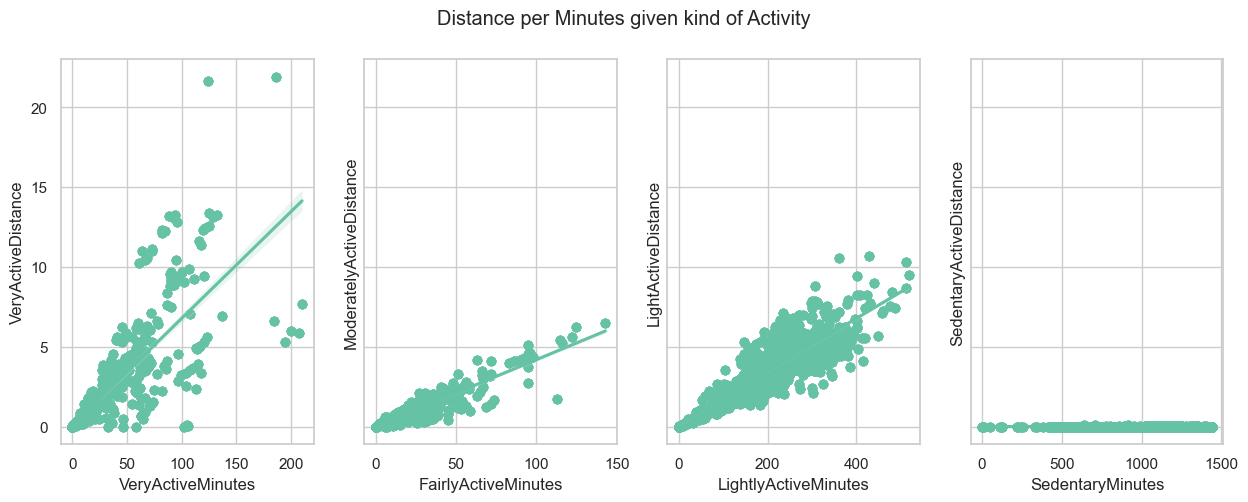

In [17]:
# 将数据探索可视化
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Distance per Minutes given kind of Activity')

sns.regplot(data = dailyActivity_df, x = 'VeryActiveMinutes', y = 'VeryActiveDistance', ax=axes[0])

sns.regplot(data = dailyActivity_df, x = 'FairlyActiveMinutes', y = 'ModeratelyActiveDistance', ax=axes[1])

sns.regplot(data = dailyActivity_df, x = 'LightlyActiveMinutes', y = 'LightActiveDistance', ax=axes[2])

sns.regplot(data = dailyActivity_df, x = 'SedentaryMinutes', y = 'SedentaryActiveDistance', ax=axes[3])


正如预期的那样，剧烈活动的距离在较短的时间内被完成（即，其速度更快，用更陡的回归线表示）。在这里，一个略显意外的结果是，"轻度活动分钟"比"适度活动分钟"带来了更大的速度。了解这个分类是如何完成的，以便真正理解"轻度"活动和"适度"活动之间的区别，将会很有趣。

intercept: 1665.742676875833
slope: [0.08351327]


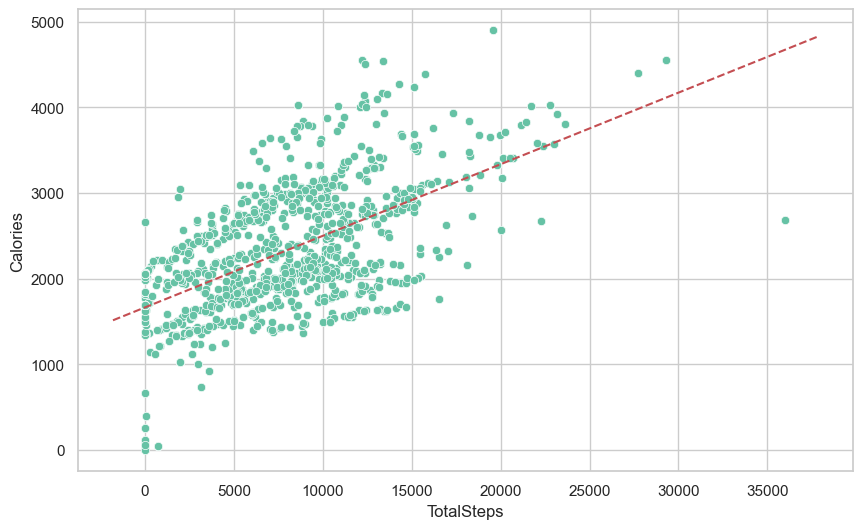

In [18]:
#线性回归拟合总步数和卡路里
X = full_dailyActivity_df['TotalSteps'].values.reshape((-1, 1))
y = full_dailyActivity_df['Calories'].values

model = LinearRegression()
model.fit(X, y)

print('intercept:', model.intercept_)
print('slope:', model.coef_)

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color= 'r', ls = '--')
    
sns.scatterplot(data = full_dailyActivity_df, x= 'TotalSteps', y ='Calories')
abline(model.coef_, model.intercept_);


再次如我们所预期，用户每天燃烧的卡路里数量随着步数的增加而增加。一个有趣的事实是，回归线的截距代表了用户在一天内没有走路时燃烧的卡路里数量。这是用户在非常久坐的一天中燃烧的卡路里数量。根据Healthline网站的数据，这个数字对应的是基础代谢率。

如果我们知道用户的性别、体重、身高和年龄，就可以计算出这个值。

例如，他们报告说，一个35岁、体重175磅、身高5英尺11英寸的男性的基础代谢率为1816卡路里，而一个35岁、体重135磅、身高5英尺5英寸的女性的基础代谢率为1383卡路里。

为了将这些估计值与我们的数据进行比较，我们可以使用线性回归获取截距值。

预测的基础代谢率约为1665.74（介于35岁的女性和男性的预测值之间）。

如果我们只过滤出步数为零的数据点，就可以进一步获取我们用户的基础代谢率信息，并获取卡路里分布的统计数据。

In [19]:
full_dailyActivity_df[full_dailyActivity_df['TotalSteps']==0]['Calories'].describe()

'''从名为full_dailyActivity_df的DataFrame中筛选出"TotalSteps"列的值为0的行，
并计算这些行中"Calories"列的统计描述性统计信息。
有助于了解在那些没有步行的情况下，消耗的卡路里情况。这可以用来分析活动和卡路里之间的关系，
或者识别不活跃的时间段，以采取适当的行动来提高活动水平。'''

'从名为full_dailyActivity_df的DataFrame中筛选出"TotalSteps"列的值为0的行，\n并计算这些行中"Calories"列的统计描述性统计信息。\n有助于了解在那些没有步行的情况下，消耗的卡路里情况。这可以用来分析活动和卡路里之间的关系，\n或者识别不活跃的时间段，以采取适当的行动来提高活动水平。'

In [20]:
full_dailyActivity_df[full_dailyActivity_df['Calories']==0]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,day,month,year,dow
30,1503960366,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None
653,6290855005,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None
817,8253242879,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None
879,8583815059,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None
970,1503960366,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None
1593,6290855005,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None
1757,8253242879,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None
1819,8583815059,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None
1910,1503960366,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None
2533,6290855005,-0-0-0-0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0,None,None,None,None




有很多行的数据都是零，除了SedentaryMinutes列。在这一列中，我们看到用户在一天内的久坐活动时间达到了1440分钟。

这就是整整一天：1440分钟除以60分钟/小时 = 24小时。

所以，看起来可能是追踪器在整个日子里都被关闭了，或者可能是出现了一些故障。在进一步的分析中，我们应该去掉这些数据点。

In [21]:
# query full_info_activity
#查询full_info_activity
full_info_activity = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow
FROM 
	dailyActivity_merged
WHERE
	Calories <> 0;
"""

full_dailyActivity_df = pd.read_sql(full_info_activity, con)

len(full_dailyActivity_df)

5616

数据集仅包含 4 行不可用数据

intercept: 1689.1510000144021
slope: [0.08138959]


(1689.1510000144021, array([0.08138959]))

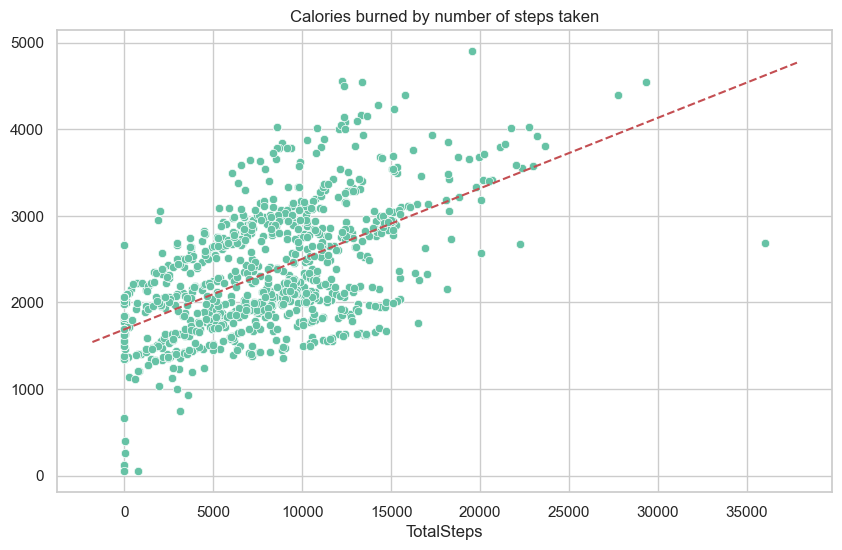

In [22]:
# 拟合每天的总步数和卡路里
# fit a line for full daily activity and get intercept and slope 
#拟合一条full daily activity的线并获得截距和斜率
def get_regression(full_dailyActivity_df, x ='TotalSteps', y = 'Calories'):
    X = full_dailyActivity_df[x].values.reshape((-1, 1))
    y = full_dailyActivity_df[y].values

    model = LinearRegression()
    model.fit(X, y)

    print('intercept:', model.intercept_)
    print('slope:', model.coef_)

    sns.scatterplot(data = full_dailyActivity_df, x= x, y =y)
    plt.title('Calories burned by number of steps taken')
    abline(model.coef_, model.intercept_);

    return (model.intercept_, model.coef_)

get_regression(full_dailyActivity_df)

看一下 VeryActiveMinutes、FairlyActiveMinutes 和 LightlyActiveMinutes 的数据分布

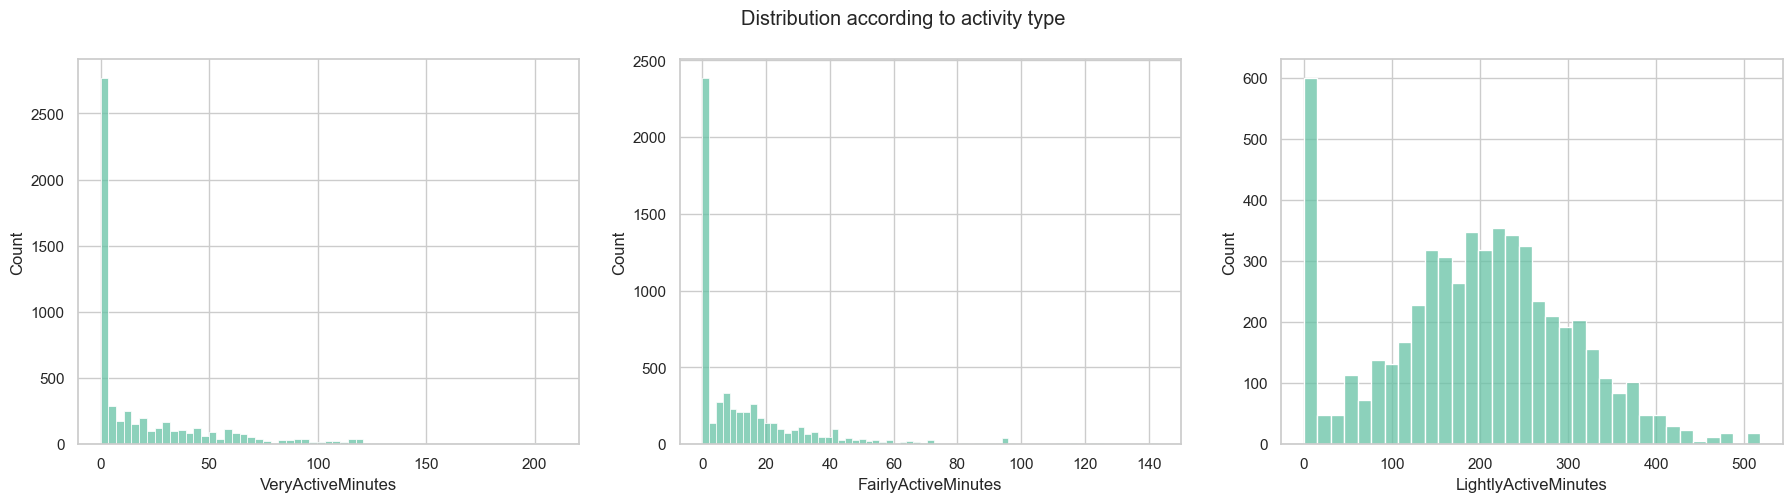

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution according to activity type')

sns.histplot(data = full_dailyActivity_df, x = 'VeryActiveMinutes', ax = axes[0]);

sns.histplot(data = full_dailyActivity_df, x = 'FairlyActiveMinutes', ax = axes[1]);

sns.histplot(data = full_dailyActivity_df, x = 'LightlyActiveMinutes', ax = axes[2]);

这里有一个问题：不清楚是否所有用户在分析期间的一整天都在使用跟踪器。 如果用户记录一整天，则 VeryActiveMinutes + FairlyActiveMinutes + LightlyActiveMinutes + SedentaryMinutes 之和应等于 1440 分钟（一天的总分钟数）。

In [24]:
full_day_activity = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow,
	VeryActiveMinutes+FairlyActiveMinutes+LightlyActiveMinutes+SedentaryMinutes AS TotalMinutes
FROM 
	dailyActivity_merged
WHERE
	Calories <> 0 AND
	TotalMinutes = 1440;
"""

logged_day_df = pd.read_sql(full_day_activity, con)

#print(f'There are {len(logged_day_df)} (out of {len(full_dailyActivity_df)}) rows where users logged the whole day.')
print(f'有 {len(logged_day_df)} 行(总行数为 {len(full_dailyActivity_df)})  记录了用户一整天的数据.')

有 2844 行(总行数为 5616)  记录了用户一整天的数据.


In [26]:
not_full_day = """
SELECT *,
	STRFTIME('%d',ActivityDate) day,
	STRFTIME('%m',ActivityDate) month,
	STRFTIME('%Y',ActivityDate) year,
	STRFTIME('%w',ActivityDate) dow,
	VeryActiveMinutes+FairlyActiveMinutes+LightlyActiveMinutes+SedentaryMinutes AS TotalMinutes
FROM 
	dailyActivity_merged
WHERE
	Calories <> 0 AND
	TotalMinutes <> 1440;
"""

not_logged_day_df = pd.read_sql(not_full_day, con)

#print(f'There are {len(not_logged_day_df)} rows where users logged parts of the day.')
#用户记录了一天中的部分时间，共有 2310 行。
print(f'有 {len(not_logged_day_df)} 行记录了用户一天中的部分时间')

有 2772 行记录了用户一天中的部分时间


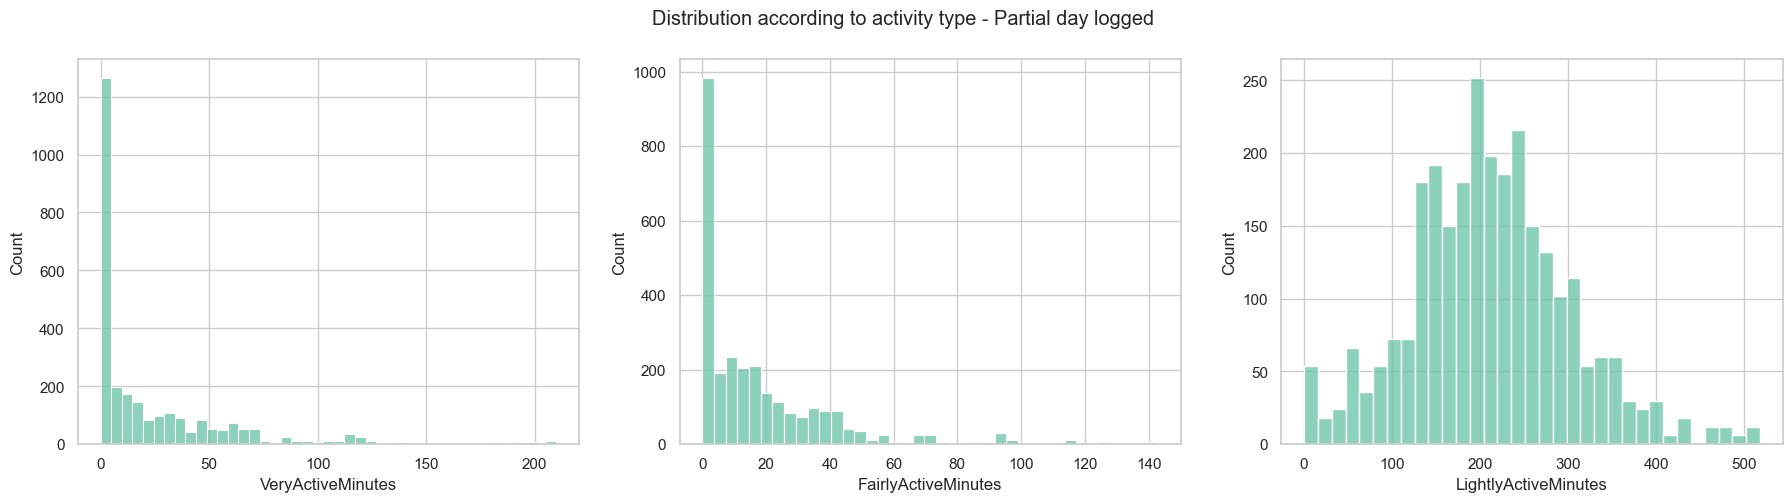

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution according to activity type - Partial day logged')

sns.histplot(data = not_logged_day_df, x = 'VeryActiveMinutes', ax = axes[0]);

sns.histplot(data = not_logged_day_df, x = 'FairlyActiveMinutes', ax = axes[1]);

sns.histplot(data = not_logged_day_df, x = 'LightlyActiveMinutes', ax = axes[2]);


LightlyActiveMinutes 分布非常对称，在活动的几分钟内没有峰值。 记录一整天的用户可能最终会注册大量的 LightlyActiveMinutes，而那些只记录一天的一部分的用户可能只会登记需求较高的活动。

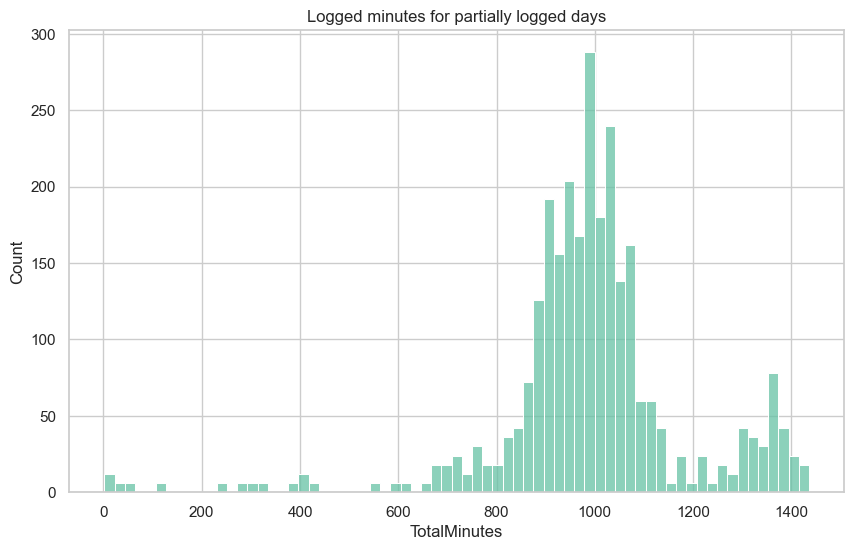

In [28]:
sns.histplot(data = not_logged_day_df, x = 'TotalMinutes')
plt.title('Logged minutes for partially logged days');

接下来查看睡眠习惯

Text(380, 30, '7h of sleep')

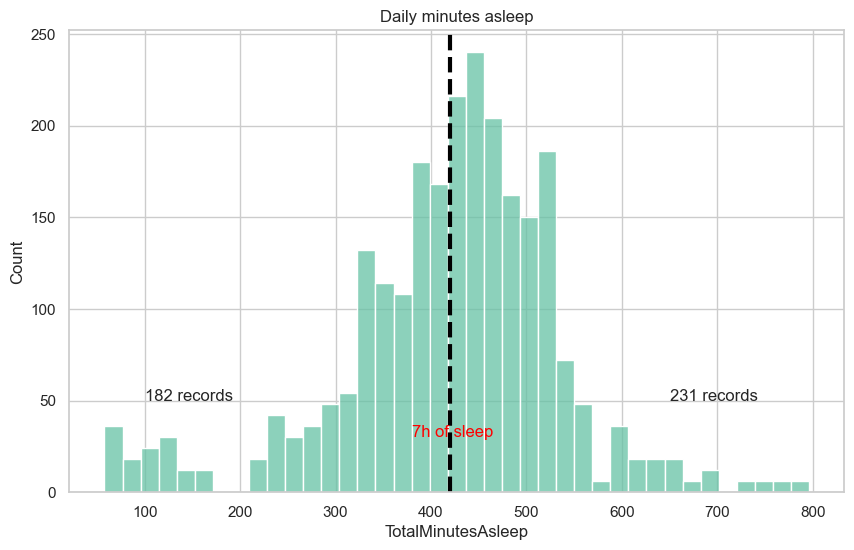

In [30]:
sns.histplot(data = sleep_df, x = 'TotalMinutesAsleep') 
'''
这段代码使用Seaborn库创建一个直方图，其中data参数是指定用于绘制直方图的数据，
x参数是指定要在直方图中显示的数据列，这里是"TotalMinutesAsleep"列。'''

plt.title('Daily minutes asleep')

plt.axvline(420, 0, 65, color='black', ls = '--', lw = 3);

plt.annotate('182 records', (100,50))
plt.annotate('231 records', (650,50))
plt.annotate('7h of sleep', (380,30), color='red')


一周中的哪一天有什么区别吗？ 现在我们已经了解了我们的数据及其分布，一周中的哪一天对用户行为有很大的影响吗？

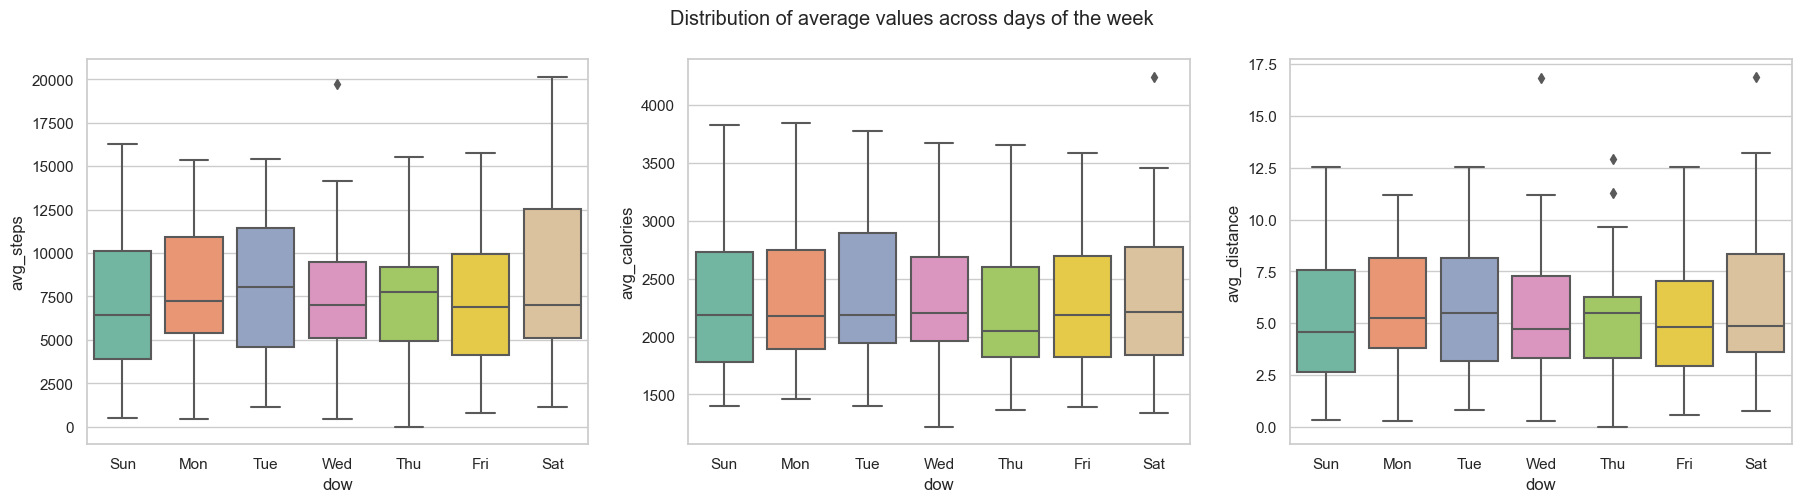

In [31]:
#一周中各天的平均值分布
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
fig.suptitle('Distribution of average values across days of the week')


sns.boxplot(x="dow", y="avg_steps", data=activity_dist, ax=axes[0]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);
sns.boxplot(x="dow", y="avg_calories", data=activity_dist, ax=axes[1]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);
sns.boxplot(x="dow", y="avg_distance", data=activity_dist, ax=axes[2]).set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri', 'Sat']);

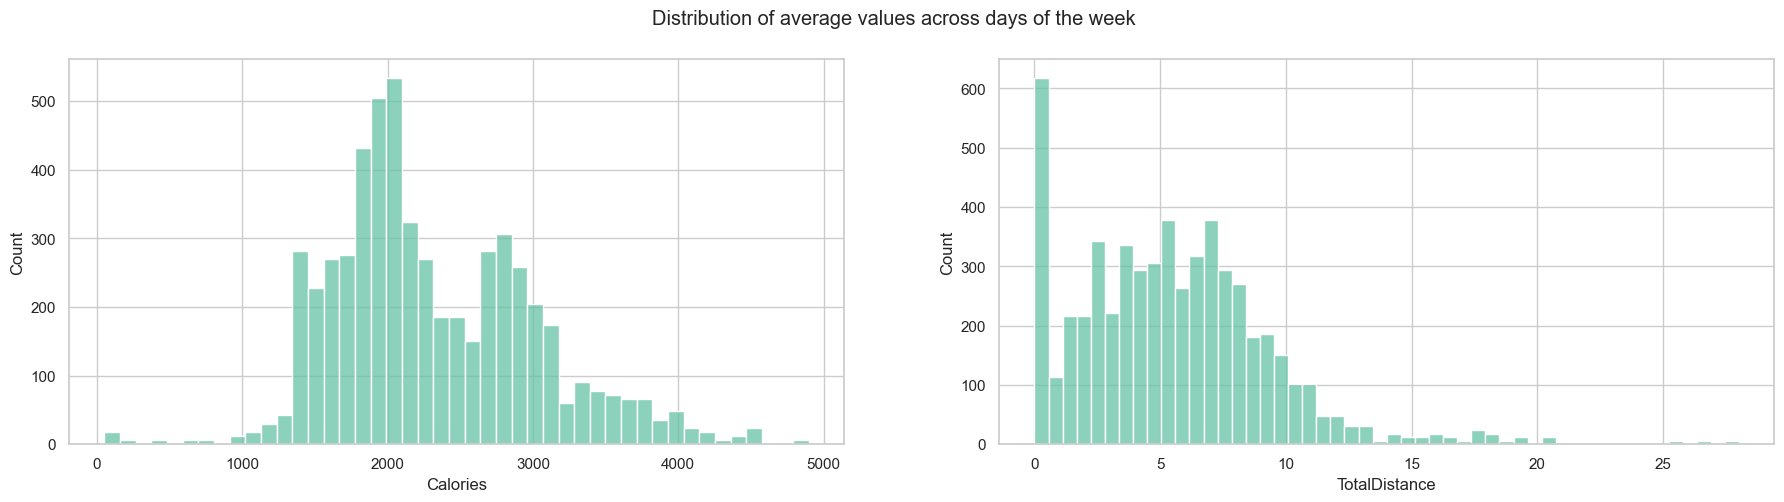

In [32]:
# distribution of calories and distance
#卡路里和距离的分布
fig, axes = plt.subplots(1, 2, figsize=(22, 5))
fig.suptitle('Distribution of average values across days of the week')

sns.histplot(data=full_dailyActivity_df, x="Calories", ax = axes[0]);

sns.histplot(data=full_dailyActivity_df, x="TotalDistance", ax = axes[1]);

周末久坐时间有何变化？

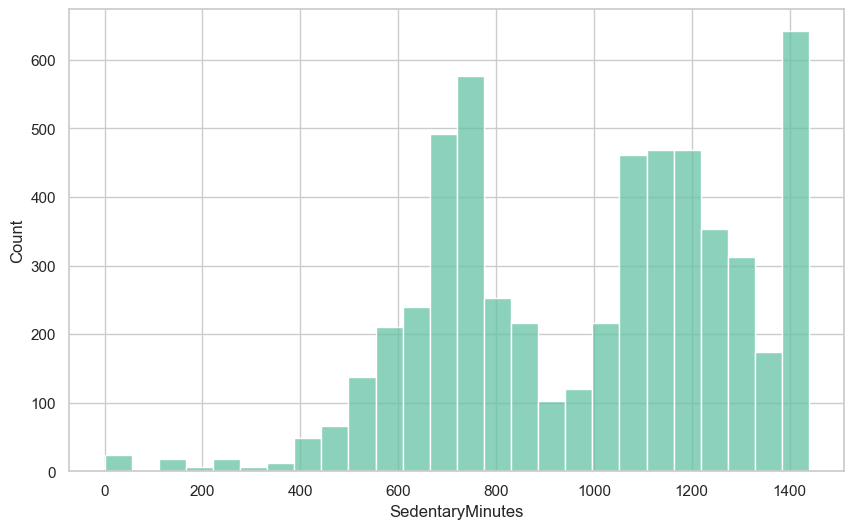

In [33]:
sns.histplot(data= weekend_check, x = 'SedentaryMinutes'); #久坐分钟数

直观地了解该分布与周末的关系

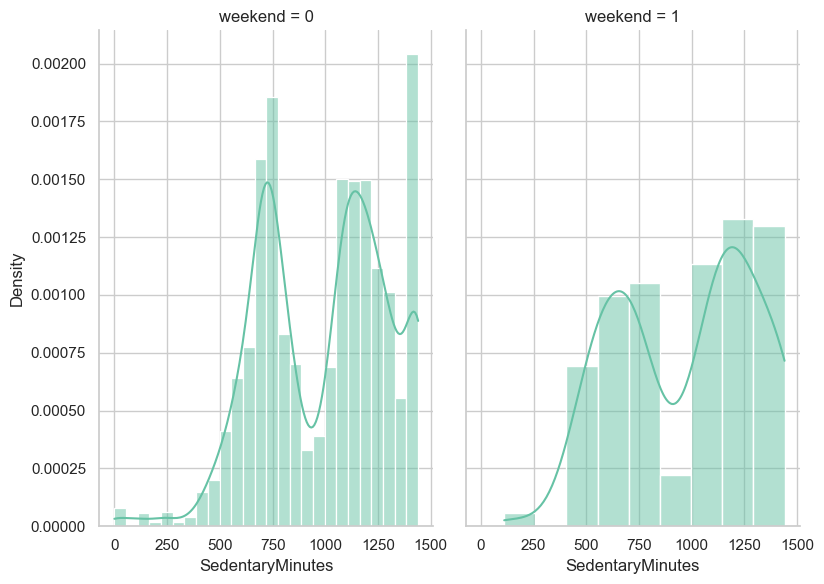

In [34]:
g = sns.FacetGrid(weekend_check, col="weekend", height=6, aspect=.7)
g.map(sns.histplot, "SedentaryMinutes", kde=True, stat='density');

现在根据久坐分钟数的分布区分两组用户

In [35]:
query = """
SELECT
	Id,
	AVG(SedentaryMinutes) AS AvgSedentaryMinutes
FROM
	dailyActivity_merged
GROUP BY
	Id
ORDER BY
	AvgSedentaryMinutes DESC;
"""
avg_sed_minutes = pd.read_sql(query, con)

avg_sed_minutes

,Id,AvgSedentaryMinutes
0,1927972279,1317.419355
1,6775888955,1299.423077
2,8253242879,1287.368421
3,8583815059,1267.225806
4,1624580081,1257.741935
5,4020332650,1237.258065
6,2320127002,1220.096774
7,4057192912,1217.250000
8,1844505072,1206.612903
9,6290855005,1193.034483


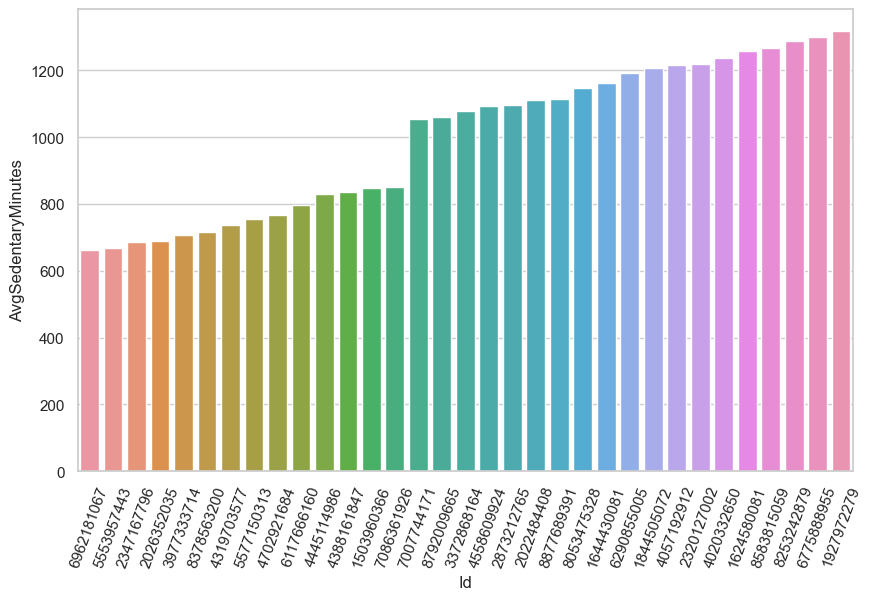

In [36]:
sns.barplot(data = avg_sed_minutes,
            x = 'Id', y = 'AvgSedentaryMinutes',
            order=avg_sed_minutes.sort_values('AvgSedentaryMinutes',ascending = True)['Id'])
plt.xticks(rotation=70);

看来我们可能已经在这里发现了一种趋势，有一个明显的偏移，似乎位于两组的边界附近。 让我们验证一下

In [37]:
# get avg sed minutes
cur.execute("SELECT	AVG(SedentaryMinutes) FROM dailyActivity_merged;")
sedMinAvg = cur.fetchall()[0][0]
print(sedMinAvg)

991.2106382978724



我们可以创建一个列来标识这个用户组。 我们将久坐时间高于平均水平的组称为第 1 组，将低于平均水平的组称为第 0 组。

第 0 组中的行数（少坐组）：
2496
第 1 组中的行数（久坐组）：
3144
第 0 组中的不同用户（少坐组）：
14
第 1 组中的不同用户（久坐组）：
19


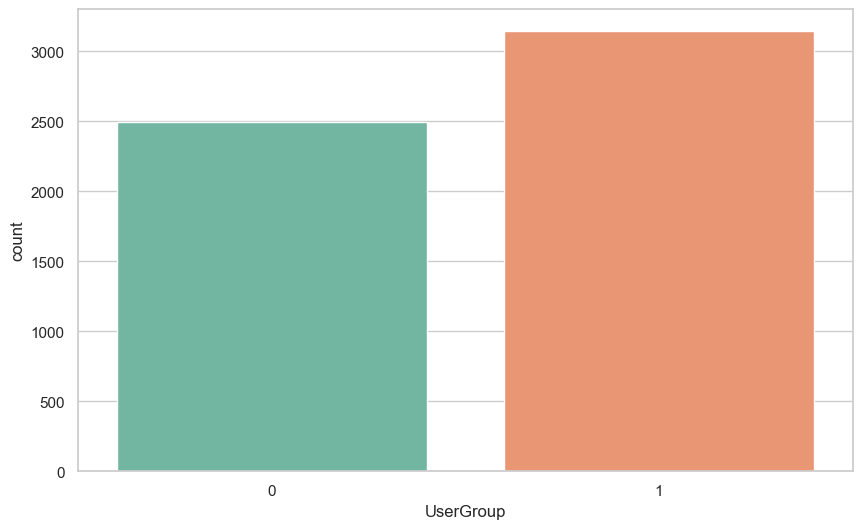

In [38]:
def is_above(user):
    '''Returns 1 if user has average SedentaryMinutes above the total average and 0 otherwise'''
    return int(avg_sed_minutes[avg_sed_minutes['Id']==user]['AvgSedentaryMinutes'].values[0] > sedMinAvg)

weekend_check['UserGroup'] = weekend_check['Id'].apply(is_above)

print(f'第 0 组中的行数（少坐组）：')
print(len(weekend_check[weekend_check['UserGroup']==0]))
print(f'第 1 组中的行数（久坐组）：')
print(len(weekend_check[weekend_check['UserGroup']==1]))

print('第 0 组中的不同用户（少坐组）：')
print(weekend_check[weekend_check['UserGroup']==0]['Id'].nunique())

print('第 1 组中的不同用户（久坐组）：')
print(weekend_check[weekend_check['UserGroup']==1]['Id'].nunique())

sns.countplot(data=weekend_check, x = 'UserGroup');

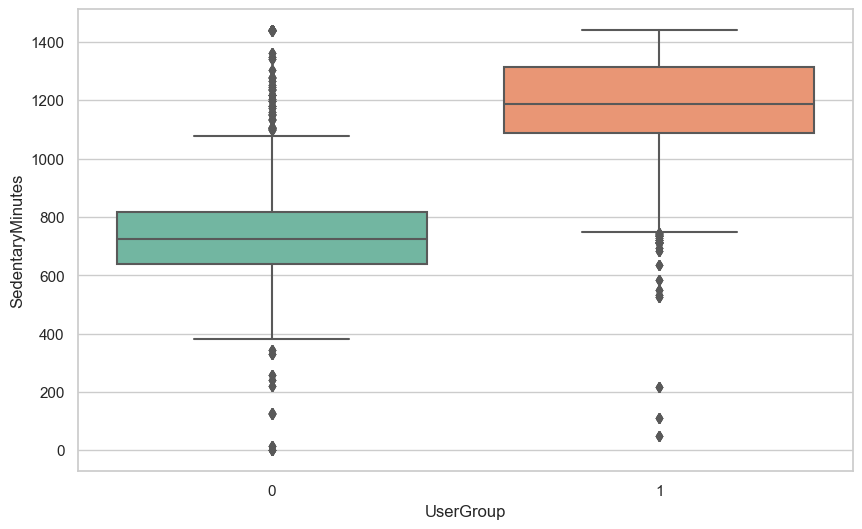

In [39]:
sns.boxplot(x="UserGroup", y="SedentaryMinutes", data=weekend_check);



每个用户群体的睡眠习惯是什么？

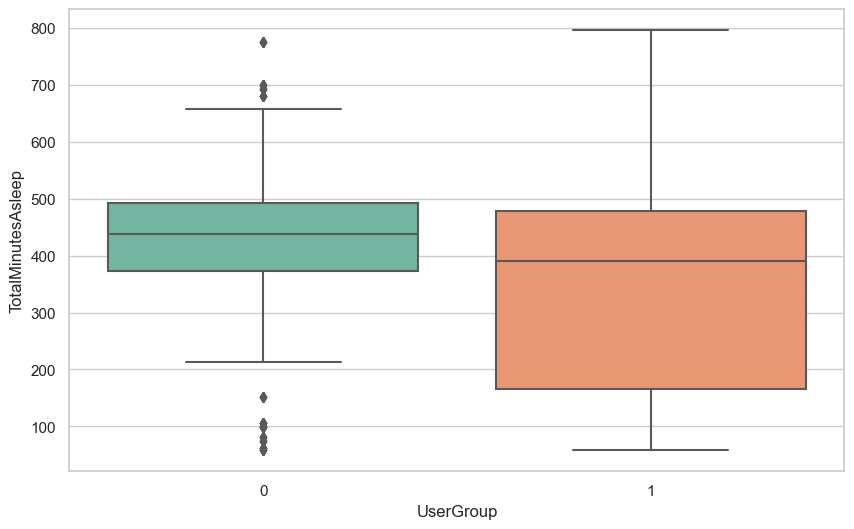

In [40]:
sleep_df['UserGroup'] = sleep_df['Id'].apply(is_above)

sns.boxplot(x="UserGroup", y="TotalMinutesAsleep", data=sleep_df);


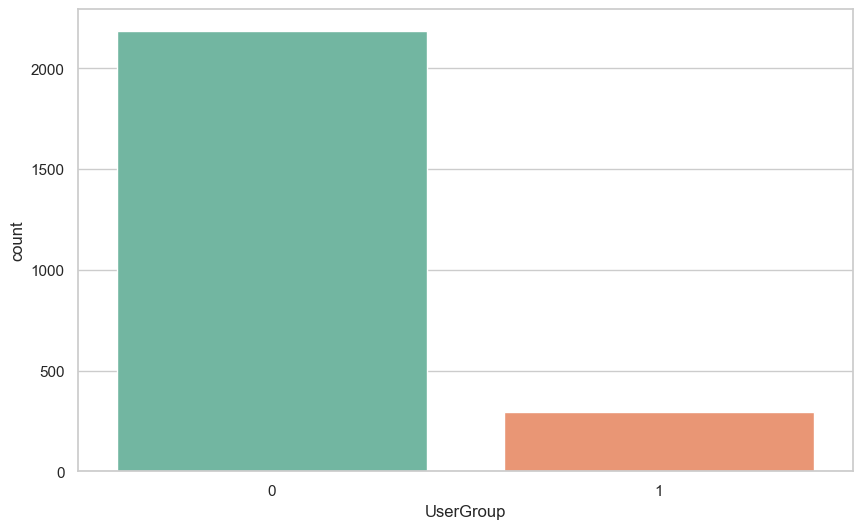

In [41]:
sns.countplot(data = sleep_df, x = 'UserGroup');

In [42]:
sleep_df['UserGroup'].value_counts()

0    2184
1     294
Name: UserGroup, dtype: int64

In [43]:
print('第0组中的不同用户（少坐组）')
print(sleep_df[sleep_df['UserGroup']==0]['Id'].nunique())

print('第1组中的不同用户（久坐组）')
print(sleep_df[sleep_df['UserGroup']==1]['Id'].nunique())

第0组中的不同用户（少坐组）
14
第1组中的不同用户（久坐组）
10


<AxesSubplot:xlabel='TotalMinutesAsleep', ylabel='SedentaryMinutes'>

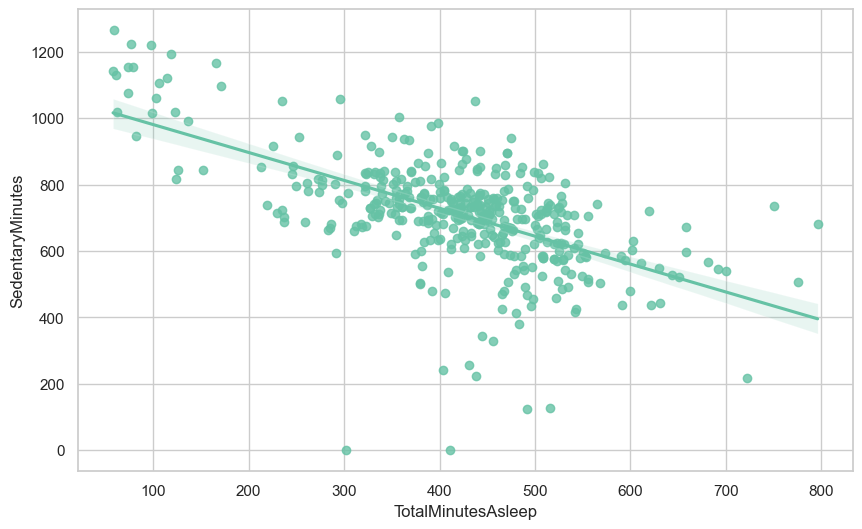

In [44]:
# 连接活动和睡眠数据
join_query = """
SELECT 
	A.Id,
	A.ActivityDate,
	A.SedentaryMinutes,
	S.TotalMinutesAsleep
FROM 
	dailyActivity_merged A
INNER JOIN sleepDay_merged S
ON 
	A.Id = S.Id AND
    A.ActivityDate = S.SleepDay;
"""
activity_sleep_df = pd.read_sql(join_query, con)

sns.regplot(data = activity_sleep_df,
                x = 'TotalMinutesAsleep',
                y = 'SedentaryMinutes')


这是一个有趣的图表，而且很有意义。

在这里，我们发现了一个明显的趋势，即睡眠时间越长的用户往往久坐的次数就越少。 这表明睡眠时间最长的用户在白天往往也更加活跃。

### 数据观察得到的结论 ###


仅通过我们33位用户的日常活动，我们得出了一些结论！

在此，我列出了一些从上述探索性分析中得出的高级见解：

一周中不同日子的用户活动没有明显区别；
每天平均步数大约为7670步。

根据CDC的一些研究：

每日步数越高，死于所有原因的风险越低。

CDC还告诉我们：

与每天走4000步（被认为是成年人的低水平）相比，每天走8000步与全因死亡率（或所有原因的死亡率）降低51%有关。每天走12000步与相比走4000步的风险降低65%有关。

如果目标是燃烧一些卡路里，我们发现走的步数和燃烧的卡路里之间存在线性关系。因此，我们可以使用用户数据来拟合一个模型，并预测用户为了达到燃烧一定数量的卡路里应该走多少步。

关于睡眠习惯，随着睡眠时间的增加，久坐时间明显减少。

因此，另一个目标可能是激励用户保持一致和充足的睡眠时间。

回到CDC的话题：
积极的体育活动有许多好处，包括降低一个人的肥胖、心脏病、2型糖尿病和某些癌症的风险。而且在日常生活中，它可以帮助人们感觉更好，睡眠更好。




基于上述探索性分析，发现所采取的步数和卡路里在某种程度上呈线性相关，并且它们一起可能表明全因死亡的风险较低。

更有趣的是，在我们的数据中，有一个尚未使用的数据集，即体重和 BMI 日志。

In [45]:
# 检查样本和数据的形状
weightLogInfo_df = pd.read_sql(f'SELECT * FROM weightLogInfo_merged', con)
print(len(weightLogInfo_df))
weightLogInfo_df.head()

402


,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,1,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,1,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,0,1460509732000
3,2873212765,4/21/2016 11:59:59 PM,56.700001,125.002104,NaN,21.450001,1,1461283199000
4,2873212765,5/12/2016 11:59:59 PM,57.299999,126.324875,NaN,21.690001,1,1463097599000



这些数据具有独特的性质，因为它们不一定是机器生成的，因此它们起到“标签”的作用。 简而言之，用户使用 Fitbit 收集有关其活动的数据，并且偶尔会记录一些身体信息，例如体重、脂肪和 BMI。

这为监督学习问题创建了一个最佳场景，例如，我们可以使用 Fitbit 活动数据来预测用户的 BMI。 这样的预测可以用来评估用户的健康状况。 此外，访问与上述监督学习问题非常相关的其他个人信息（例如身高、年龄和性别）会更有用。

我们将问题简化为卡路里预测，而卡路里被用作评估用户健康状况的主要变量。

In [46]:
join_query = """
SELECT 
	A.Id,
	A.ActivityDate,
	A.SedentaryMinutes,
    A.Calories,
    A.TotalSteps,
	S.TotalMinutesAsleep,
    S.TotalTimeInBed
FROM 
	dailyActivity_merged A
INNER JOIN sleepDay_merged S
ON 
	A.Id = S.Id AND
    A.ActivityDate = S.SleepDay;
"""

fitbit_df = pd.read_sql(join_query, con)

print(len(fitbit_df))

413


In [47]:
fitbit_df[fitbit_df.isna()].count()

Id                    0
ActivityDate          0
SedentaryMinutes      0
Calories              0
TotalSteps            0
TotalMinutesAsleep    0
TotalTimeInBed        0
dtype: int64

In [48]:
# 删除活动日期，因为这不是时间序列分析
# 删除 id，因为它不相关
fitbit_df = fitbit_df.drop(columns=['Id', 'ActivityDate'])


# 生成的组合数据如下所示
fitbit_df.head()

,SedentaryMinutes,Calories,TotalSteps,TotalMinutesAsleep,TotalTimeInBed
0,728,1985,13162,327,346
1,776,1797,10735,384,407
2,726,1745,9762,412,442
3,773,1863,12669,340,367
4,539,1728,9705,700,712


Index(['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed', 'Calories'],
      dtype='object')


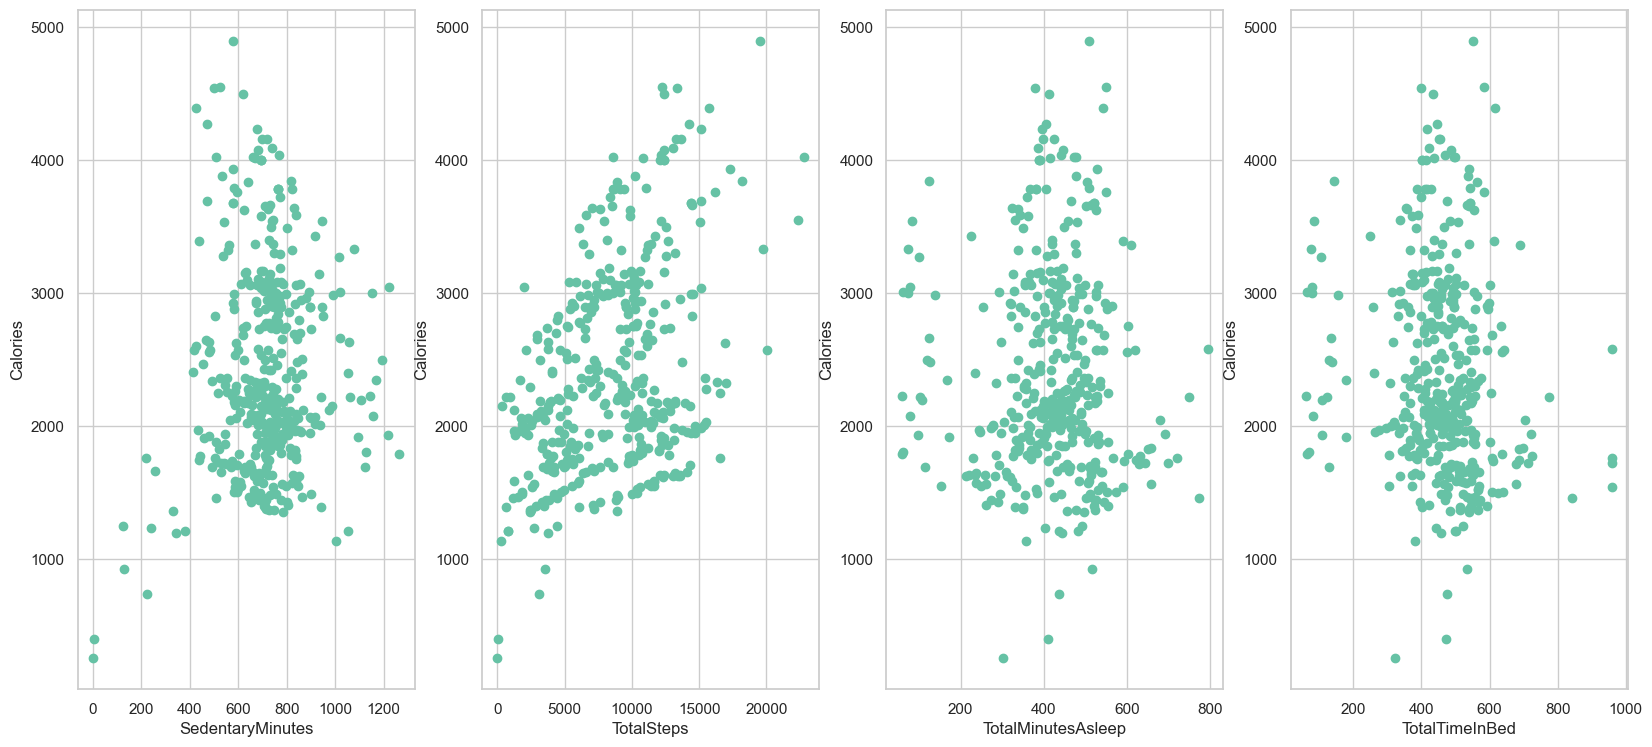

In [49]:
column_to_move = fitbit_df.pop("Calories")
fitbit_df.insert(4, "Calories", column_to_move)
print(fitbit_df.columns)

# 定义一个函数来绘制所有自变量和因变量之间关系的散点图

def plot_relationships(df, num_cols):
    variables = df.columns
    
    # assume that the dependent variable is in the last column
    # 假设因变量在最后一列
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # 循环遍历所有自变量并创建散点图
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(fitbit_df,4)

<AxesSubplot:>

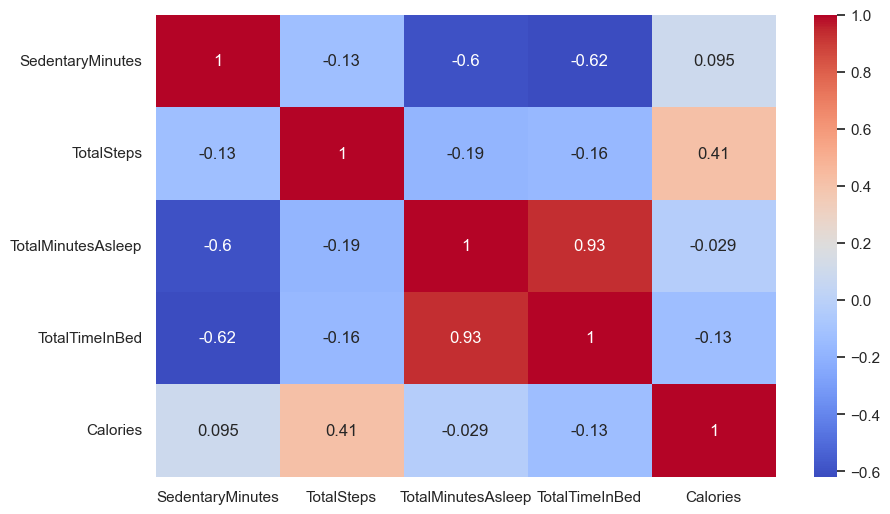

In [50]:
# Plot the correlations as a heatmap
#将相关性绘制为热图
plt.figure(figsize=(10, 6))
sns.heatmap(fitbit_df.corr(), annot=True, cmap='coolwarm', fmt='.2g')

### 使用机器学习  ###

#以这样的方式分割数据：训练集占总数据集的 60%，验证集和测试集均占 20%。 接下来的代码实现了正确的百分比分割

In [51]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(fitbit_df.iloc[:,:-1], 
                                                              fitbit_df['Calories'], 
                                                              test_size=0.2, 
                                                              random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, 
                                                      test_size=0.25, random_state=42)

In [52]:
# scale the data with object range of 0-1
#归一化：使用 0-1 的对象范围缩放数据
scaler = MinMaxScaler()

scaler.fit_transform(X_train)

scaler.transform(X_valid)
scaler.transform(X_test)

array([[0.63330599, 0.36764383, 0.40785908, 0.37555556],
       [0.59557014, 0.45576408, 0.57859079, 0.48777778],
       [0.6997539 , 0.0528282 , 0.5799458 , 0.49111111],
       [0.56193601, 0.54379642, 0.44715447, 0.38444444],
       [0.90730107, 0.20476421, 0.06504065, 0.05222222],
       [0.61443806, 0.31455193, 0.38617886, 0.33222222],
       [0.39294504, 0.42082363, 0.73441734, 0.63888889],
       [0.59639048, 0.49997802, 0.49186992, 0.44      ],
       [0.54060705, 0.47061926, 0.49728997, 0.41555556],
       [0.6923708 , 0.60326111, 0.09214092, 0.08444444],
       [0.3388023 , 0.35990858, 0.57181572, 0.53888889],
       [0.5561936 , 0.36171054, 0.59891599, 0.55111111],
       [0.62674323, 0.23829825, 0.47425474, 0.43222222],
       [0.58736669, 0.30769569, 0.61382114, 0.53555556],
       [0.47087777, 0.40047466, 0.63821138, 0.55222222],
       [0.73420837, 0.08996616, 0.44715447, 0.40333333],
       [0.43478261, 0.28774228, 0.6504065 , 0.55444444],
       [0.47497949, 0.8581286 ,

In [53]:
#测试模型的函数
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
# Create list of median predictions that has the same length as y_valid
# 创建与 y_valid 长度相同的中值预测列表
baseline_y = [y_train.median()] * len(y_valid)

# Compute the relevant scores
# 计算相关分数

base_predictions = baseline_y
base_mae = mean_absolute_error(y_valid, base_predictions)
base_mse = mean_squared_error(y_valid, base_predictions)
base_r2 = r2_score(y_valid, base_predictions)
base_errors = abs(base_predictions - y_valid)
base_mape = 100 * np.mean(base_errors / y_valid)
base_accuracy = 100 - base_mape
print('Model Performance')
print('Mean Absolute Error: {:0.4f}.'.format(base_mae))
print('Mean Squared Error: {:0.4f}.'.format(base_mse))
print('R^2 Score = {:0.4f}.'.format(base_r2))
print('Accuracy = {:0.2f}%.'.format(base_accuracy))

Model Performance
Mean Absolute Error: 649.0120.
Mean Squared Error: 650005.8072.
R^2 Score = -0.0292.
Accuracy = 72.74%.



我们希望根据每次预测平均值的模型的性能建立基线分数。 基线可用于评估我们要训练的模型是否实际上从数据中“学习”任何内容。

Text(0, 0.5, 'Coefficients')

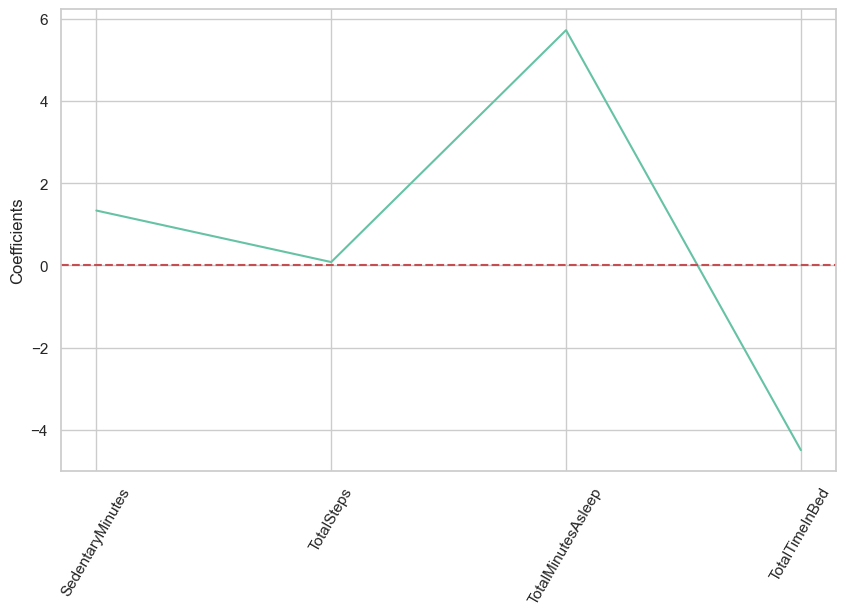

In [54]:
# feature selection with lasso Regression
# 使用套索回归进行特征选择
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

plt.figure(figsize=(10, 6))
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.axhline(0.0, linestyle='--', color='r')
plt.ylabel('Coefficients')


套索回归算法表明，通过在模型中包含所有特征，我们可能不会面临任何重大的多重共线性问题。

### Part3 机器学习建模 ####

In [55]:
print(X_train) #有四个特征：久坐时间、总步数、总睡眠时间、总床上时间
print(y_train)  #每行有索引和数据
print(type(X_train))
print(type(y_train))

first_data = y_train.iloc[0]
print(first_data)  #查看第一个样本的预期输出

     SedentaryMinutes  TotalSteps  TotalMinutesAsleep  TotalTimeInBed
390               764        8567                 381             417
367               680       12386                 447             487
51                626        6375                 513             545
233               943         655                 350             402
260               776        5077                 432             458
..                ...         ...                 ...             ...
35               1058        3761                 296             315
210               469       15126                 465             475
248               724        9769                 409             471
263               472       14269                 406             445
96                714        7193                 349             540

[247 rows x 4 columns]
390    3783
367    4079
51     1649
233    1397
260    2551
       ... 
35     2638
210    3691
248    1996
263    4274
96     1377
Name

### 多元线性回归 ####

In [56]:
regressor = LinearRegression()
mlr = regressor.fit(X_train, y_train)

scoring(mlr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 571.5923.
Mean Squared Error: 461353.1211.
R^2 Score = 0.2695.
Accuracy = 74.79%.


### 随机森林 ###

In [57]:
rf_regressor = rf_sk(random_state=42)
rf = rf_regressor.fit(X_train, y_train)

scoring(rf, X_valid, y_valid)

Model Performance
Mean Absolute Error: 506.9816.
Mean Squared Error: 407747.2590.
R^2 Score = 0.3544.
Accuracy = 77.49%.


### 极端梯度提升 ###

In [58]:
xgb_regressor = XGBRegressor(random_state=42)
xgb = xgb_regressor.fit(X_train, y_train)

scoring(xgb, X_valid, y_valid)

Model Performance
Mean Absolute Error: 499.4119.
Mean Squared Error: 419972.2894.
R^2 Score = 0.3350.
Accuracy = 78.23%.


### 交叉验证和参数超级调整 ###

In [59]:
# Define a function that compares the CV perfromance of a set of predetrmined models 
# 定义一个函数来比较一组预定模型的 CV 性能
#交叉验证比较函数
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

In [60]:
# Create the models to be tested
# 创建要测试的线性模型、随机森林、极端梯度提升
mlr_reg = LinearRegression()
rf_reg = rf_sk(random_state=42)
xgb_reg = xgb_regressor = XGBRegressor(random_state=42)

models1 = [mlr_reg, rf_reg, xgb_reg]

# Run the Cross-Validation comparison with the models used in this analysis
comp1, maes, mses, r2s1, accs = cv_comparison(models1, X_train_temp, y_train_temp, 4)

comp1

,LinearRegression(),RandomForestRegressor(random_state=42),"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, gamma=None,\n gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, n_estimators=100, n_jobs=None,\n num_parallel_tree=None, predictor=None, random_state=42,\n reg_alpha=None, reg_lambda=None, ...)"
Mean Absolute Error,523.9734,471.8517,482.7019
Mean Squared Error,410459.2050,371613.2164,406833.3769
R^2,0.2813,0.3468,0.2825
Accuracy,78.3106,80.4681,80.0190


In [61]:
# Set hyperparameters possibilities for tuning Random Forest
## 设置调整随机森林的超参数可能性
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
rf_max_depth.append(None)
rf_max_features = ['auto', 'sqrt', 'log2']
rf_criterion = ['mse', 'mae']
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['mse', 'mae'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

In [62]:
print(X_train_temp)
print(y_train_temp)

     SedentaryMinutes  TotalSteps  TotalMinutesAsleep  TotalTimeInBed
238               781       11682                 322             353
5                 775       15506                 304             320
45                749        2467                 477             514
110              1222        1982                  77              77
258               222        3121                 438             475
..                ...         ...                 ...             ...
71                648        6711                 465             514
106               703       11550                 237             443
270               627        7638                 384             402
348               706       10091                 446             447
102               594       14335                 292             500

[330 rows x 4 columns]
238    2105
5      2035
45     1370
110    3051
258     741
       ... 
71     2346
106    1574
270    3152
348    2752
102    1710
Name

In [64]:
rf_base = rf_sk(criterion='squared_error')

rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42)

rf_random.fit(X_train_temp, y_train_temp)

rf_random.best_estimator_ #包含了经过随机搜索后性能最佳的随机森林模型的配置。


Fitting 3 folds for each of 200 candidates, totalling 600 fits


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=15, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=15, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=15, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=1000; total time=   1.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=1000; total time=   1.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=1000; total time=   1.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=400; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=400; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=400; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=1000; total time=   1.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=1000; total time=   1.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=1000; total time=   1.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=400; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=400; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=400; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=15, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=15, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=15, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=600; total time=   1.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=600; total time=   1.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=600; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=400; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=400; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=400; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=25, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=25, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=25, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=800; total time=   0.4s
[CV] END bootstrap=False, criterion=mse, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, criterion=mse, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=25, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=25, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=25, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=15, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=15, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=15, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=600; total time=   1.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=1000; total time=   1.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=1000; total time=   1.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=1000; total time=   1.8s
[CV] END bootstrap=True, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=600; total time=   1.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=log2, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=log2, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=log2, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   1.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   1.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   1.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.7s
[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=auto, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=auto, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=auto, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=400; total time=   0.1s
[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=15, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=15, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=15, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=400; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=400; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=400; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=log2, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=log2, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=log2, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=log2, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=log2, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=log2, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=800; total time=   1.4s
[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=log2, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=log2, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=600; total time=   0.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=log2, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=600; total time=   1.0s
[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=auto, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=auto, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=auto, min_impurity_decrease=0.1, min_samples_split=3, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=400; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=400; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   1.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=40, max_features=log2, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=600; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=600; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=50, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   1.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=50, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=50, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=1000; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=1000; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=1000; total time=   1.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=20, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=20, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=20, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   0.4s
[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.05, min_samples_split=7, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.05, min_samples_split=7, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.05, min_samples_split=7, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=10, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=10, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=10, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=600; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=600; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=600; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=800; total time=   1.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   2.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   2.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   2.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=auto, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=auto, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=auto, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=25, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=9, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=1000; total time=   1.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=1000; total time=   1.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=1000; total time=   1.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=800; total time=   1.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=50, max_features=auto, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=50, max_features=auto, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=50, max_features=auto, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=1000; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=1000; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=1000; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=1000; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=1000; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=1000; total time=   1.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=45, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=log2, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=auto, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=log2, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=log2, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=log2, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=1000; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=1000; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=auto, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=1000; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=None, max_features=auto, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=None, max_features=auto, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=None, max_features=auto, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=1000; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=auto, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=auto, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=auto, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   1.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.2s
[CV] END bootstrap=True, criterion=mse, max_depth=15, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=15, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, criterion=mse, max_depth=15, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=auto, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=auto, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=auto, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=log2, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=log2, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=25, max_features=log2, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=log2, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=auto, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=auto, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=auto, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=600; total time=   0.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=35, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=45, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=45, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=45, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=800; total time=   2.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=800; total time=   1.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=800; total time=   2.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   0.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=log2, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=log2, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=log2, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=auto, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=auto, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=auto, min_impurity_decrease=0.0, min_samples_split=7, n_estimators=400; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, criterion=mse, max_depth=40, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=40, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=mse, max_depth=40, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=600; total time=   0.8s
[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=400; total time=   0.1s
[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=40, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   1.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=40, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   1.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=40, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=600; total time=   1.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=15, max_features=log2, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=5, max_features=auto, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=800; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=800; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=800; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   2.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   2.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   2.4s
[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=log2, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=1000; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=log2, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=1000; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=log2, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=1000; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=log2, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=200; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=45, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=5, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=800; total time=   1.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=log2, min_impurity_decrease=0.05, min_samples_split=7, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=log2, min_impurity_decrease=0.05, min_samples_split=7, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=log2, min_impurity_decrease=0.05, min_samples_split=7, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=50, max_features=auto, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=50, max_features=auto, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=50, max_features=auto, min_impurity_decrease=0.1, min_samples_split=10, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=40, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=800; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=40, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=800; total time=   1.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=40, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=800; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=1000; total time=   0.6s
[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=log2, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=log2, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=log2, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=35, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=25, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=600; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=25, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=25, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=log2, min_impurity_decrease=0.05, min_samples_split=9, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=log2, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=log2, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=40, max_features=log2, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=1000; total time=   0.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=30, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=30, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=30, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=3, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=log2, min_impurity_decrease=0.1, min_samples_split=4, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=auto, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=600; total time=   0.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=auto, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=600; total time=   0.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=10, max_features=auto, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, criterion=mse, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=mse, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=55, max_features=auto, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=None, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=1000; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=1000; total time=   2.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=1000; total time=   1.9s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=2, n_estimators=1000; total time=   2.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=log2, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=600; total time=   1.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=log2, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=600; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=log2, min_impurity_decrease=0.05, min_samples_split=4, n_estimators=600; total time=   1.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=400; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=2, n_estimators=400; total time=   0.8s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=auto, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=auto, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=40, max_features=auto, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=1000; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=1000; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=55, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=3, n_estimators=1000; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=800; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=auto, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=auto, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=auto, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=1000; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=1000; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=55, max_features=log2, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=1000; total time=   1.6s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=20, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=35, max_features=auto, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=35, max_features=auto, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=35, max_features=auto, min_impurity_decrease=0.1, min_samples_split=5, n_estimators=200; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=15, max_features=log2, min_impurity_decrease=0.05, min_samples_split=7, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=15, max_features=log2, min_impurity_decrease=0.05, min_samples_split=7, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=15, max_features=log2, min_impurity_decrease=0.05, min_samples_split=7, n_estimators=800; total time=   0.5s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=log2, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=log2, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=50, max_features=log2, min_impurity_decrease=0.1, min_samples_split=7, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, criterion=mse, max_depth=5, max_features=sqrt, min_impurity_decrease=0.05, min_samples_split=6, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=auto, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=auto, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=30, max_features=auto, min_impurity_decrease=0.05, min_samples_split=10, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=30, max_features=log2, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=30, max_features=log2, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=600; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=30, max_features=log2, min_impurity_decrease=0.0, min_samples_split=9, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=30, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=30, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=30, max_features=sqrt, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=600; total time=   0.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=40, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=40, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.2s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=40, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=10, n_estimators=400; total time=   0.2s
[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=auto, min_impurity_decrease=0.05, min_samples_split=2, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=600; total time=   0.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=55, max_features=log2, min_impurity_decrease=0.1, min_samples_split=8, n_estimators=600; total time=   0.3s
[CV] END bootstrap=True, criterion=mse, max_depth=40, max_features=auto, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=200; total time=   0.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mse, max_depth=40, max_features=auto, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, criterion=mse, max_depth=40, max_features=auto, min_impurity_decrease=0.05, min_samples_split=8, n_estimators=200; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=5, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1000; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=5, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1000; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=5, max_features=log2, min_impurity_decrease=0.05, min_samples_split=5, n_estimators=1000; total time=   1.0s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mse, max_depth=10, max_features=log2, min_impurity_decrease=0.0, min_samples_split=4, n_estimators=400; total time=   0.1s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=True, criterion=mae, max_depth=45, max_features=auto, min_impurity_decrease=0.1, min_samples_split=6, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   2.7s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   2.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=None, max_features=auto, min_impurity_decrease=0.0, min_samples_split=8, n_estimators=1000; total time=   2.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=800; total time=   1.3s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


[CV] END bootstrap=False, criterion=mae, max_depth=30, max_features=sqrt, min_impurity_decrease=0.0, min_samples_split=6, n_estimators=800; total time=   1.4s


D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mae', max_depth=15, max_features='log2',
                      min_impurity_decrease=0.05, min_samples_split=3,
                      n_estimators=600)

In [65]:
# Set hyperparameters possibilities for tuning XGBoost
# 设置调整 XGBoost 的超参数可能性
xgb_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

In [66]:
# Tune the XGBoost Model
#调整XGBoost模型
xgb_base = XGBRegressor()

xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 42)

xgb_random.fit(X_train_temp, y_train_temp)

xgb_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] END eta=0.5, gamma=0, max_depth=8, min_child_weight=10, n_estimators=200, objective=reg:squaredlogerror, tree_method=hist; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=8, min_child_weight=10, n_estimators=200, objective=reg:squaredlogerror, tree_method=hist; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=8, min_child_weight=10, n_estimators=200, objective=reg:squaredlogerror, tree_method=hist; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=8, min_child_weight=8, n_estimators=400, objective=reg:squaredlogerror, tree_method=approx; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=8, min_child_weight=8, n_estimators=400, objective=reg:squaredlogerror, tree_method=approx; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=8, min_child_weight=8, n_estimators=400, objective=reg:squaredlogerror, tree_method=approx; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=8, min_child_we

[CV] END eta=0.2, gamma=0, max_depth=20, min_child_weight=5, n_estimators=800, objective=reg:squaredlogerror, tree_method=auto; total time=   0.1s
[CV] END eta=0.2, gamma=0, max_depth=20, min_child_weight=5, n_estimators=800, objective=reg:squaredlogerror, tree_method=auto; total time=   0.1s
[CV] END eta=0.30000000000000004, gamma=0, max_depth=20, min_child_weight=9, n_estimators=600, objective=reg:squaredlogerror, tree_method=auto; total time=   0.0s
[CV] END eta=0.30000000000000004, gamma=0, max_depth=20, min_child_weight=9, n_estimators=600, objective=reg:squaredlogerror, tree_method=auto; total time=   0.0s
[CV] END eta=0.30000000000000004, gamma=0, max_depth=20, min_child_weight=9, n_estimators=600, objective=reg:squaredlogerror, tree_method=auto; total time=   0.0s
[CV] END eta=0.1, gamma=0, max_depth=2, min_child_weight=7, n_estimators=400, objective=reg:squarederror, tree_method=exact; total time=   0.0s
[CV] END eta=0.1, gamma=0, max_depth=2, min_child_weight=7, n_estimators=

[CV] END eta=0.30000000000000004, gamma=0, max_depth=10, min_child_weight=9, n_estimators=800, objective=reg:squaredlogerror, tree_method=auto; total time=   0.1s
[CV] END eta=0.30000000000000004, gamma=0, max_depth=10, min_child_weight=9, n_estimators=800, objective=reg:squaredlogerror, tree_method=auto; total time=   0.1s
[CV] END eta=0.30000000000000004, gamma=0, max_depth=10, min_child_weight=9, n_estimators=800, objective=reg:squaredlogerror, tree_method=auto; total time=   0.1s
[CV] END eta=0.2, gamma=0, max_depth=8, min_child_weight=8, n_estimators=800, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.2, gamma=0, max_depth=8, min_child_weight=8, n_estimators=800, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.2, gamma=0, max_depth=8, min_child_weight=8, n_estimators=800, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.30000000000000004, gamma=0, max_depth=8, min_child_weig

[CV] END eta=0.5, gamma=0, max_depth=18, min_child_weight=8, n_estimators=200, objective=reg:squaredlogerror, tree_method=hist; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=18, min_child_weight=8, n_estimators=200, objective=reg:squaredlogerror, tree_method=hist; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=16, min_child_weight=2, n_estimators=200, objective=reg:squaredlogerror, tree_method=auto; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=16, min_child_weight=2, n_estimators=200, objective=reg:squaredlogerror, tree_method=auto; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=16, min_child_weight=2, n_estimators=200, objective=reg:squaredlogerror, tree_method=auto; total time=   0.0s
[CV] END eta=0.1, gamma=0, max_depth=10, min_child_weight=4, n_estimators=200, objective=reg:squaredlogerror, tree_method=gpu_hist; total time=   0.1s
[CV] END eta=0.1, gamma=0, max_depth=10, min_child_weight=4, n_estimators=200, objective=reg:squaredlogerror, tree

[CV] END eta=0.1, gamma=0, max_depth=6, min_child_weight=1, n_estimators=400, objective=reg:squaredlogerror, tree_method=exact; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=4, min_child_weight=2, n_estimators=1000, objective=reg:squarederror, tree_method=exact; total time=   0.2s
[CV] END eta=0.2, gamma=0, max_depth=4, min_child_weight=2, n_estimators=1000, objective=reg:squarederror, tree_method=exact; total time=   0.2s
[CV] END eta=0.2, gamma=0, max_depth=4, min_child_weight=2, n_estimators=1000, objective=reg:squarederror, tree_method=exact; total time=   0.2s
[CV] END eta=0.1, gamma=0, max_depth=14, min_child_weight=5, n_estimators=1000, objective=reg:squaredlogerror, tree_method=approx; total time=   0.2s
[CV] END eta=0.1, gamma=0, max_depth=14, min_child_weight=5, n_estimators=1000, objective=reg:squaredlogerror, tree_method=approx; total time=   0.2s
[CV] END eta=0.1, gamma=0, max_depth=14, min_child_weight=5, n_estimators=1000, objective=reg:squaredlogerror, tree_me

[CV] END eta=0.6, gamma=0, max_depth=18, min_child_weight=6, n_estimators=400, objective=reg:squarederror, tree_method=approx; total time=   0.2s
[CV] END eta=0.6, gamma=0, max_depth=18, min_child_weight=6, n_estimators=400, objective=reg:squarederror, tree_method=approx; total time=   0.2s
[CV] END eta=0.5, gamma=0, max_depth=6, min_child_weight=7, n_estimators=800, objective=reg:squarederror, tree_method=auto; total time=   0.2s
[CV] END eta=0.5, gamma=0, max_depth=6, min_child_weight=7, n_estimators=800, objective=reg:squarederror, tree_method=auto; total time=   0.1s
[CV] END eta=0.5, gamma=0, max_depth=6, min_child_weight=7, n_estimators=800, objective=reg:squarederror, tree_method=auto; total time=   0.1s
[CV] END eta=0.2, gamma=0, max_depth=20, min_child_weight=1, n_estimators=200, objective=reg:squarederror, tree_method=gpu_hist; total time=   4.3s
[CV] END eta=0.2, gamma=0, max_depth=20, min_child_weight=1, n_estimators=200, objective=reg:squarederror, tree_method=gpu_hist; to

[CV] END eta=0.30000000000000004, gamma=0, max_depth=18, min_child_weight=3, n_estimators=800, objective=reg:squaredlogerror, tree_method=auto; total time=   0.1s
[CV] END eta=0.5, gamma=0, max_depth=10, min_child_weight=10, n_estimators=600, objective=reg:squaredlogerror, tree_method=hist; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=10, min_child_weight=10, n_estimators=600, objective=reg:squaredlogerror, tree_method=hist; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=10, min_child_weight=10, n_estimators=600, objective=reg:squaredlogerror, tree_method=hist; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=2, min_child_weight=5, n_estimators=600, objective=reg:squarederror, tree_method=approx; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=2, min_child_weight=5, n_estimators=600, objective=reg:squarederror, tree_method=approx; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=2, min_child_weight=5, n_estimators=600, objective=reg:squarederro

[CV] END eta=0.1, gamma=0, max_depth=14, min_child_weight=9, n_estimators=400, objective=reg:squaredlogerror, tree_method=gpu_hist; total time=   0.5s
[CV] END eta=0.1, gamma=0, max_depth=14, min_child_weight=9, n_estimators=400, objective=reg:squaredlogerror, tree_method=gpu_hist; total time=   0.4s
[CV] END eta=0.2, gamma=0, max_depth=2, min_child_weight=1, n_estimators=400, objective=reg:squaredlogerror, tree_method=auto; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=2, min_child_weight=1, n_estimators=400, objective=reg:squaredlogerror, tree_method=auto; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=2, min_child_weight=1, n_estimators=400, objective=reg:squaredlogerror, tree_method=auto; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=10, min_child_weight=2, n_estimators=1000, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.5, gamma=0, max_depth=10, min_child_weight=2, n_estimators=1000, objective=reg:squaredlogerror, 

[CV] END eta=0.1, gamma=0, max_depth=12, min_child_weight=4, n_estimators=1000, objective=reg:squarederror, tree_method=hist; total time=   0.5s
[CV] END eta=0.1, gamma=0, max_depth=12, min_child_weight=4, n_estimators=1000, objective=reg:squarederror, tree_method=hist; total time=   0.4s
[CV] END eta=0.1, gamma=0, max_depth=12, min_child_weight=4, n_estimators=1000, objective=reg:squarederror, tree_method=hist; total time=   0.4s
[CV] END eta=0.4, gamma=0, max_depth=2, min_child_weight=6, n_estimators=200, objective=reg:squaredlogerror, tree_method=gpu_hist; total time=   0.1s
[CV] END eta=0.4, gamma=0, max_depth=2, min_child_weight=6, n_estimators=200, objective=reg:squaredlogerror, tree_method=gpu_hist; total time=   0.1s
[CV] END eta=0.4, gamma=0, max_depth=2, min_child_weight=6, n_estimators=200, objective=reg:squaredlogerror, tree_method=gpu_hist; total time=   0.1s
[CV] END eta=0.1, gamma=0, max_depth=4, min_child_weight=9, n_estimators=800, objective=reg:squaredlogerror, tree_m

[CV] END eta=0.2, gamma=0, max_depth=2, min_child_weight=1, n_estimators=400, objective=reg:squaredlogerror, tree_method=exact; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=2, min_child_weight=1, n_estimators=400, objective=reg:squaredlogerror, tree_method=exact; total time=   0.0s
[CV] END eta=0.2, gamma=0, max_depth=2, min_child_weight=1, n_estimators=400, objective=reg:squaredlogerror, tree_method=exact; total time=   0.0s
[CV] END eta=0.5, gamma=0, max_depth=4, min_child_weight=1, n_estimators=1000, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.5, gamma=0, max_depth=4, min_child_weight=1, n_estimators=1000, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.5, gamma=0, max_depth=4, min_child_weight=1, n_estimators=1000, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.1, gamma=0, max_depth=8, min_child_weight=10, n_estimators=200, objective=reg:squaredlogerror, tree_

[CV] END eta=0.30000000000000004, gamma=0, max_depth=2, min_child_weight=7, n_estimators=400, objective=reg:squaredlogerror, tree_method=hist; total time=   0.0s
[CV] END eta=0.6, gamma=0, max_depth=20, min_child_weight=5, n_estimators=800, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.6, gamma=0, max_depth=20, min_child_weight=5, n_estimators=800, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.6, gamma=0, max_depth=20, min_child_weight=5, n_estimators=800, objective=reg:squaredlogerror, tree_method=exact; total time=   0.1s
[CV] END eta=0.30000000000000004, gamma=0, max_depth=10, min_child_weight=4, n_estimators=600, objective=reg:squarederror, tree_method=approx; total time=   0.2s
[CV] END eta=0.30000000000000004, gamma=0, max_depth=10, min_child_weight=4, n_estimators=600, objective=reg:squarederror, tree_method=approx; total time=   0.2s
[CV] END eta=0.30000000000000004, gamma=0, max_depth=10, min_child_wei

{'tree_method': 'gpu_hist',
 'objective': 'reg:squarederror',
 'n_estimators': 800,
 'min_child_weight': 1,
 'max_depth': 8,
 'gamma': 0,
 'eta': 0.1}

In [67]:
#最终模型比较函数
# 定义一个比较所有最终模型的函数
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores

In [68]:
# 创建最终的多元线性回归
mlr_final = LinearRegression()

# 创建最终的随机森林
rf_final = rf_sk(n_estimators = 600,
                                 min_samples_split = 4,
                                 min_impurity_decrease = 0.05,
                                 max_features = 'sqrt',
                                 max_depth = 15,
                                 criterion = 'mae',
                                 bootstrap = True,
                                 random_state = 42)

# 创建最终的极端梯度助推器
xgb_final = XGBRegressor(tree_method = 'approx',
                         objective = 'reg:squarederror',
                         n_estimators = 80,
                         min_child_weight = 4,
                         max_depth = 12,
                         gamma = 0,
                         eta = 0.1,
                         random_state = 42)

# 使用 80% 的原始数据训练模型
mlr_final.fit(X_train_temp, y_train_temp)
rf_final.fit(X_train_temp, y_train_temp)
xgb_final.fit(X_train_temp, y_train_temp)

# 与此分析中使用的模型进行交叉验证比较
models3 = [mlr_final, rf_final, xgb_final]
comp3, maes, mses, r2s3, accs = cv_comparison(models3, X_train_temp, y_train_temp, 4)

comp3

D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
D:\yyyykk\Anaconda202011\envs\pytorchcode\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
 

,LinearRegression(),"RandomForestRegressor(criterion='mae', max_depth=15, max_features='sqrt',\n min_impurity_decrease=0.05, min_samples_split=4,\n n_estimators=600, random_state=42)","XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False, eta=0.1,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,\n max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=4,\n missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,\n num_parallel_tree=1, predictor='auto', random_state=42,\n reg_alpha=0, ...)"
Mean Absolute Error,523.9734,471.0235,480.2028
Mean Squared Error,410459.2050,357106.2011,395490.2946
R^2,0.2813,0.3733,0.3028
Accuracy,78.3106,80.5025,80.1224


### 深度学习 ###

In [71]:
#数据处理

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
X_train1 = X_train
y_train1 = y_train
X_valid1 = X_valid
y_valid1 = y_valid
#删除无效数据
X_train = X_train.dropna()
y_train = y_train.dropna()

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_train_tensor = y_train_tensor.view(-1, 1) # 将y_train_tensor的形状从[247]改为[247, 1]
# 将输入数据（X_train）和标签数据（y_train）转移到相同的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)



In [ ]:


#线性回归等效的pytorch深度学习模型


# 定义一个简单的线性回归模型
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# 超参数
input_size = 4  # 特征数量
# 初始化模型
model1 = LinearRegressionModel(input_size)
model1.to(device)

# 定义损失函数和优化器
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)



# 训练模型
num_epochs = 10000
for epoch in range(num_epochs):
    # 前向传播
    outputs = model1(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1)
    optimizer.step()

    # 打印损失值（每1000个epoch）
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')



torch.save(model1.state_dict(), '.\\Creative_model\\jupyter_LinearRegressionModel.pth')

In [75]:
#加载已经训练好的模型1

# 定义一个简单的线性回归模型
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)
# 超参数
input_size = 4  # 特征数量
model1 = LinearRegressionModel(input_size)
model1.to(device)
# 定义损失函数和优化器
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

model1.load_state_dict(torch.load('C:\\Users\\Administrator\\Desktop\\andachi\\jupyter_LinearRegressionModel.pth'))
# num_epochs = 100000
# for epoch in range(num_epochs):
#     # 前向传播
#     outputs = model1(X_train_tensor)
#     loss = criterion(outputs, y_train_tensor)

#     # 反向传播和优化
#     optimizer.zero_grad()
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1)
#     optimizer.step()

#     # 打印损失值（每1000个epoch）
#     if epoch % 1000 == 0:
#         print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
# torch.save(model1.state_dict(), '.\\Creative_model\\jupyter_LinearRegressionModel.pth')

<All keys matched successfully>

In [92]:
#纯深度模型
import torch.nn as nn

class VeryDeepRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VeryDeepRegressionModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)
        ])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output_layer(x)
        return x

# 超参数
input_size = 4  # 特征数量
hidden_size = 64  # 每个隐藏层的神经元数量
num_layers = 20  # 隐藏层的数量
output_size = 1

# 初始化20层深度模型
model2 = VeryDeepRegressionModel(input_size, hidden_size, num_layers, output_size)
model2.to(device)
# 定义损失函数，通常用均方误差（Mean Squared Error）
criterion = nn.MSELoss()

# 定义优化器，通常使用随机梯度下降（SGD）或其他优化器
learning_rate = 0.001
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)







# 训练模型
num_epochs = 10000
for epoch in range(num_epochs):
    # 前向传播
    outputs = model2(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1)
    optimizer.step()

    # 打印损失值（每1000个epoch）
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
torch.save(model2.state_dict(), '.\\Creative_model\\jupyter_VeryDeepRegressionModel.pth')

Epoch [0/10000], Loss: 6410511.5
Epoch [1000/10000], Loss: 416136.09375
Epoch [2000/10000], Loss: 570781.625
Epoch [3000/10000], Loss: 310748.78125
Epoch [4000/10000], Loss: 878411.1875
Epoch [5000/10000], Loss: 390489.125
Epoch [6000/10000], Loss: 298567.0625
Epoch [7000/10000], Loss: 193598.421875
Epoch [8000/10000], Loss: 138979.171875
Epoch [9000/10000], Loss: 144689.21875


In [93]:
#加载训练好的模型2
class VeryDeepRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VeryDeepRegressionModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)
        ])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output_layer(x)
        return x
# 超参数
input_size = 4  # 特征数量
hidden_size = 64  # 每个隐藏层的神经元数量
num_layers = 20  # 隐藏层的数量
output_size = 1

# 初始化20层深度模型
model2 = VeryDeepRegressionModel(input_size, hidden_size, num_layers, output_size)

model2.to(device)
model2.load_state_dict(torch.load('C:\\Users\\Administrator\\Desktop\\andachi\\jupyter_VeryDeepRegressionModel.pth'))
# 定义损失函数，通常用均方误差（Mean Squared Error）
criterion = nn.MSELoss()

# 定义优化器，通常使用随机梯度下降（SGD）或其他优化器
learning_rate = 0.001
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)



num_epochs = 100001
for epoch in range(num_epochs):
    # 前向传播
    outputs = model2(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1)
    optimizer.step()

    # 打印损失值（每1000个epoch）
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
torch.save(model1.state_dict(), '.\\Creative_model\\jupyter_VeryDeepRegressionModel.pth')

Epoch [0/100001], Loss: 282597.6875
Epoch [1000/100001], Loss: 92522.8203125
Epoch [2000/100001], Loss: 82206.65625
Epoch [3000/100001], Loss: 48805.40234375
Epoch [4000/100001], Loss: 84405.8203125
Epoch [5000/100001], Loss: 57962.37890625
Epoch [6000/100001], Loss: 100289.0546875
Epoch [7000/100001], Loss: 54651.1953125
Epoch [8000/100001], Loss: 14187.5244140625
Epoch [9000/100001], Loss: 80565.1328125
Epoch [10000/100001], Loss: 40885.32421875
Epoch [11000/100001], Loss: 77075.1640625
Epoch [12000/100001], Loss: 45259.3984375
Epoch [13000/100001], Loss: 23988.984375
Epoch [14000/100001], Loss: 19389.78515625
Epoch [15000/100001], Loss: 42453.85546875
Epoch [16000/100001], Loss: 47570.55859375
Epoch [17000/100001], Loss: 7792.7744140625
Epoch [18000/100001], Loss: 14007.6884765625
Epoch [19000/100001], Loss: 194366.609375
Epoch [20000/100001], Loss: 49129.265625
Epoch [21000/100001], Loss: 24037.34765625
Epoch [22000/100001], Loss: 23251.439453125
Epoch [23000/100001], Loss: 12627.2

In [ ]:
#有残差块的深度模型

import torch
import torch.nn as nn
import torch.optim as optim

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(out_features, out_features)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x += residual  # 添加残差连接
        return x

class VeryDeepRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VeryDeepRegressionModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            ResidualBlock(hidden_size, hidden_size) for _ in range(num_layers - 1)
        ])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)  # 使用残差块
            x = torch.relu(x)
        x = self.output_layer(x)
        return x

# 超参数
input_size = 4  # 特征数量
hidden_size = 64  # 每个隐藏层的神经元数量
num_layers = 20  # 隐藏层的数量
output_size = 1

# 初始化带有残差块的深度模型
model3 = VeryDeepRegressionModel(input_size, hidden_size, num_layers, output_size)
model3.to(device)

# 定义损失函数，通常使用均方误差（MSE）
criterion = nn.MSELoss()

# 定义优化器，通常使用随机梯度下降（SGD）或其他优化器
learning_rate = 0.001
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model3.parameters(), lr=learning_rate)



# 训练模型
num_epochs = 10000
for epoch in range(num_epochs):
    # 前向传播
    outputs = model3(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1)
    optimizer.step()

    # 打印损失值（每1000个epoch）
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
        
torch.save(model3.state_dict(), '.\\Creative_model\\jupyter_ResidualBlock_VeryDeepRegressionModel.pth')

In [77]:
#加载训练好的模型3
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(out_features, out_features)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x += residual  # 添加残差连接
        return x

class VeryDeepRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VeryDeepRegressionModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            ResidualBlock(hidden_size, hidden_size) for _ in range(num_layers - 1)
        ])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)  # 使用残差块
            x = torch.relu(x)
        x = self.output_layer(x)
        return x

# 超参数
input_size = 4  # 特征数量
hidden_size = 64  # 每个隐藏层的神经元数量
num_layers = 20  # 隐藏层的数量
output_size = 1

# 初始化带有残差块的深度模型
model3 = VeryDeepRegressionModel(input_size, hidden_size, num_layers, output_size)
model3.to(device)
model3.load_state_dict(torch.load('C:\\Users\\Administrator\\Desktop\\andachi\\jupyter_ResidualBlock_VeryDeepRegressionModel.pth'))


# 定义损失函数，通常使用均方误差（MSE）
criterion = nn.MSELoss()

# 定义优化器，通常使用随机梯度下降（SGD）或其他优化器
learning_rate = 0.001
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model3.parameters(), lr=learning_rate)



# # 训练模型
# num_epochs = 100000
# for epoch in range(num_epochs):
#     # 前向传播
#     outputs = model3(X_train_tensor)
#     loss = criterion(outputs, y_train_tensor)

#     # 反向传播和优化
#     optimizer.zero_grad()
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1)
#     optimizer.step()

#     # 打印损失值（每1000个epoch）
#     if epoch % 1000 == 0:
#         print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
        
# torch.save(model3.state_dict(), '.\\Creative_model\\jupyter_ResidualBlock_VeryDeepRegressionModel.pth')

In [ ]:
#优化残差块，加入批量归一化层和dropout层
import torch
import torch.nn as nn
import torch.optim as optim

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)  # 批量归一化层
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)  # 批量归一化层

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.bn1(x)  # 添加批量归一化
        x = self.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)  # 添加批量归一化
        x += residual  # 添加残差连接
        return x

class VeryDeepRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_p):
        super(VeryDeepRegressionModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            ResidualBlock(hidden_size, hidden_size) for _ in range(num_layers - 1)
        ])
        self.dropout = nn.Dropout(dropout_p)  # Dropout层
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)  # 使用残差块
            x = torch.relu(x)
        x = self.dropout(x)  # 添加Dropout
        x = self.output_layer(x)
        return x

# 超参数
input_size = 4  # 特征数量
hidden_size = 64  # 每个隐藏层的神经元数量
num_layers = 20  # 隐藏层的数量
output_size = 1
dropout_p = 0.5  # Dropout的概率

# 初始化带有残差块的深度模型
model4 = VeryDeepRegressionModel(input_size, hidden_size, num_layers, output_size, dropout_p)
model4.to(device)

# 定义损失函数，通常使用均方误差（MSE）
criterion = nn.MSELoss()

# 定义优化器，通常使用随机梯度下降（SGD）或其他优化器
learning_rate = 0.001
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model4.parameters(), lr=learning_rate)



# 训练模型
num_epochs = 10000
for epoch in range(num_epochs):
    # 前向传播
    outputs = model4(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model4.parameters(), max_norm=1)
    optimizer.step()

    # 打印损失值（每1000个epoch）
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
torch.save(model4.state_dict(), '.\\Creative_model\\jupyter_VeryDeepRegressionModel_BatchNorm1d_Dropou.pth')

In [78]:
#加载训练好的模型4
import torch
import torch.nn as nn
import torch.optim as optim

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)  # 批量归一化层
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)  # 批量归一化层

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.bn1(x)  # 添加批量归一化
        x = self.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)  # 添加批量归一化
        x += residual  # 添加残差连接
        return x

class VeryDeepRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_p):
        super(VeryDeepRegressionModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            ResidualBlock(hidden_size, hidden_size) for _ in range(num_layers - 1)
        ])
        self.dropout = nn.Dropout(dropout_p)  # Dropout层
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)  # 使用残差块
            x = torch.relu(x)
        x = self.dropout(x)  # 添加Dropout
        x = self.output_layer(x)
        return x

# 超参数
input_size = 4  # 特征数量
hidden_size = 64  # 每个隐藏层的神经元数量
num_layers = 20  # 隐藏层的数量
output_size = 1
dropout_p = 0.3  # Dropout的概率

# 初始化带有残差块的深度模型
model4 = VeryDeepRegressionModel(input_size, hidden_size, num_layers, output_size, dropout_p)
model4.to(device)
model4.load_state_dict(torch.load('C:\\Users\\Administrator\\Desktop\\andachi\\jupyter_VeryDeepRegressionModel_BatchNorm1d_Dropou.pth'))

# 定义损失函数，通常使用均方误差（MSE）
criterion = nn.MSELoss()

# 定义优化器，通常使用随机梯度下降（SGD）或其他优化器
learning_rate = 0.001
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model4.parameters(), lr=learning_rate)



# # 训练模型
# num_epochs = 100000
# for epoch in range(num_epochs):
#     # 前向传播
#     outputs = model4(X_train_tensor)
#     loss = criterion(outputs, y_train_tensor)

#     # 反向传播和优化
#     optimizer.zero_grad()
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model4.parameters(), max_norm=1)
#     optimizer.step()

#     # 打印损失值（每1000个epoch）
#     if epoch % 1000 == 0:
#         print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
# torch.save(model4.state_dict(), '.\\Creative_model\\jupyter_VeryDeepRegressionModel_BatchNorm1d_Dropou.pth')

In [79]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def deep_learning_scoring(model, test_features, test_labels, i):
    model.to('cpu')
    # 获取模型的预测值
    predictions = model(test_features)

    # 计算回归性能指标
# 计算回归性能指标
    mae = mean_absolute_error(test_labels.detach().numpy(), predictions.detach().numpy())
    mse = mean_squared_error(test_labels.detach().numpy(), predictions.detach().numpy())

    rmse = np.sqrt(mse)
    r2 = r2_score(test_labels.detach().numpy(), predictions.detach().numpy())


    # 计算自定义评估指标（示例中使用MAPE）
    errors = torch.abs(predictions - test_labels)
    mape = 100 * torch.mean(errors / test_labels).detach().numpy()


    # 计算准确率
    accuracy = 100 - mape

    print('Model{} Performance'.format(i))
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('Root Mean Squared Error: {:0.4f}.'.format(rmse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    #print('Custom MAPE Score = {:0.2f}%.'.format(accuracy))
    print('Custom accuracy = {:0.2f}%.'.format(accuracy))
    print('\n')

In [94]:
# 验证模型
# X_train = X_train.astype('float32')
# y_train = y_train.astype('float32')
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# y_train_tensor = y_train_tensor.view(-1, 1)
# X_train_tensor = X_train_tensor.to(device)
# y_train_tensor = y_train_tensor.to(device)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32)
y_valid_tensor = y_valid_tensor.view(-1, 1)


models = [model1, model2, model3, model4]

# with torch.no_grad():
#     predictions = model(X_valid_tensor)

# # 计算性能指标
# mae = mean_absolute_error(y_valid_tensor, predictions)
# mse = mean_squared_error(y_valid_tensor, predictions)
# r2 = r2_score(y_valid_tensor, predictions)
i = 0
for model in models:
    i += 1
    deep_learning_scoring(model,X_valid_tensor, y_valid_tensor, i )



Model1 Performance
Mean Absolute Error: 575.0211.
Mean Squared Error: 467607.2812.
Root Mean Squared Error: 683.8182.
R^2 Score = 0.2596.
Custom accuracy = 74.72%.


Model2 Performance
Mean Absolute Error: 630.8237.
Mean Squared Error: 779047.2500.
Root Mean Squared Error: 882.6365.
R^2 Score = -0.2335.
Custom accuracy = 74.50%.


Model3 Performance
Mean Absolute Error: 631.5220.
Mean Squared Error: 748088.5625.
Root Mean Squared Error: 864.9211.
R^2 Score = -0.1845.
Custom accuracy = 74.72%.


Model4 Performance
Mean Absolute Error: 488.8828.
Mean Squared Error: 499453.8750.
Root Mean Squared Error: 706.7205.
R^2 Score = 0.2092.
Custom accuracy = 79.65%.




In [ ]:
X_train = X_train1
y_train = y_train1
X_valid = X_valid1
y_valid = y_valid1

In [95]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def cv_comparison_pytorch(models, X, y, cv):
    # 将 DataFrame 转换为 NumPy 数组
    X = X.values
    y = y.values
    
    # 将 NumPy 数组转换为 PyTorch Tensor
    

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)


    
    y = y.view(-1, 1) # 将y_train_tensor的形状从[247]改为[247, 1]
    # 将输入数据（X_train）和标签数据（y_train）转移到相同的设备
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     X = X.to(device)
#     y = y.to(device) 
    
    print(type(X))
    print(type(y))
    
    
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []

    for model in models:
        model.eval()  # 将模型设置为评估模式
        mae_scores = []
        mse_scores = []
        r2_scores = []
        acc_scores = []

        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            with torch.no_grad():
                predictions = model(X_test)

            mae = mean_absolute_error(y_test, predictions)
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)

            mae_scores.append(mae)
            mse_scores.append(mse)
            r2_scores.append(r2)

            errors = torch.abs(predictions - y_test)
            accuracy = 100 - (100 * torch.mean(errors / y_test)).item()
            acc_scores.append(accuracy)


        mae_avg = round(np.mean(mae_scores), 4)
        mse_avg = round(np.mean(mse_scores), 4)
        r2_avg = round(np.mean(r2_scores), 4)
        acc_avg = round(np.mean(acc_scores), 4)

        maes.append(mae_scores)
        mses.append(mse_scores)
        r2s.append(r2_scores)
        accs.append(acc_scores)

        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]

    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']

    return cv_accuracies, maes, mses, r2s, accs

models2 = [model1, model2, model3, model4]

# 创建一个交叉验证对象
cv = KFold(n_splits=4, shuffle=True, random_state=42)

# 运行交叉验证比较
comp2, maes, mses, r2s2, accs = cv_comparison_pytorch(models2, X_train_temp, y_train_temp, cv)


comp2


<class 'torch.Tensor'>
<class 'torch.Tensor'>


LinearRegressionModel(\n  (linear): Linear(in_features=4, out_features=1, bias=True)\n)  \
Mean Absolute Error                                         519.924316                                         
Mean Squared Error                                       404599.062500                                         
R^2                                                           0.279600                                         
Accuracy                                                     77.412100                                         

                     VeryDeepRegressionModel(\n  (input_layer): Linear(in_features=4, out_features=64, bias=True)\n  (hidden_layers): ModuleList(\n    (0): Linear(in_features=64, out_features=64, bias=True)\n    (1): Linear(in_features=64, out_features=64, bias=True)\n    (2): Linear(in_features=64, out_features=64, bias=True)\n    (3): Linear(in_features=64, out_features=64, bias=True)\n    (4): Linear(in_features=64, out_features=64, bias=True)\n    (5): Linear(in_features=64, out_features=64, bias=True)\n    (6): Linear(in_features=64, out_features=64, bias=True)\n    (7): Linear(in_features=64, out_features=64, bias=True)\n    (8): Linear(in_features=64, out_features=64, bias=True)\n    (9): Linear(in_features=64, out_features=64, bias=True)\n    (10): Linear(in_features=64, out_features=64, bias=True)\n    (11): Linear(in_features=64, out_features=64, bias=True)\n    (12): Linear(in_features=64, out_features=64, bias=True)\n    (13): Linear(in_features=64, out_features=64, bias=True)\n    (14): Linear(in_features=64, out_features=64, bias=True)\n    (15): Linear(in_features=64, out_features=64, bias=True)\n    (16): Linear(in_features=64, out_features=64, bias=True)\n    (17): Linear(in_features=64, out_features=64, bias=True)\n    (18): Linear(in_features=64, out_features=64, bias=True)\n  )\n  (output_layer): Linear(in_features=64, out_features=1, bias=True)\n)  \
Mean Absolute Error                                         249.035995                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Mean Squared Error                                       212970.546875                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [96]:
print(type(comp1))
print(type(comp2))
print(comp1.shape)
print(comp2.shape)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(4, 3)
(4, 4)


In [97]:

r2_combined = np.concatenate([r2s1, r2s2], axis=0)



# 合并 comp1 和 comp2
merged_comp = pd.concat([comp1, comp2], axis=1)



# 创建 r2_comp
r2_comp = pd.DataFrame(r2_combined, index=merged_comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', '4th Fold']) #交叉验证中
#每个折叠的性能指标

# 计算平均值
r2_comp['Average'] = np.round(r2_comp.mean(axis=1), 4)

# 显示 DataFrame
r2_comp


1st Fold  2nd Fold  \
LinearRegression()                                  0.243700  0.267900   
RandomForestRegressor(random_state=42)              0.491300  0.270500   
XGBRegressor(base_score=None, booster=None, cal...  0.541800  0.256400   
LinearRegressionModel(\n  (linear): Linear(in_f...  0.259625  0.333753   
VeryDeepRegressionModel(\n  (input_layer): Line... -0.233486  0.957895   
VeryDeepRegressionModel(\n  (input_layer): Line... -0.184468  0.999989   
VeryDeepRegressionModel(\n  (input_layer): Line...  0.209202  0.904079   

                                                    3rd Fold  4th Fold  \
LinearRegression()                                  0.307200  0.306300   
RandomForestRegressor(random_state=42)              0.285900  0.339400   
XGBRegressor(base_score=None, booster=None, cal...  0.196900  0.134800   
LinearRegressionModel(\n  (linear): Linear(in_f...  0.212538  0.312487   
VeryDeepRegressionModel(\n  (input_layer): Line...  0.951228  0.955495   
VeryDeepRegressionModel(\n  (input_layer): Line...  0.999985  0.999986   
VeryDeepRegressionModel(\n  (input_layer): Line...  0.378497  0.494073   

                                                    Average  
LinearRegression()                                   0.2813  
RandomForestRegressor(random_state=42)               0.3468  
XGBRegressor(base_score=None, booster=None, cal...   0.2825  
LinearRegressionModel(\n  (linear): Linear(in_f...   0.2796  
VeryDeepRegressionModel(\n  (input_layer): Line...   0.6578  
VeryDeepRegressionModel(\n  (input_layer): Line...   0.7039  
VeryDeepRegressionModel(\n  (input_layer): Line...   0.4965

In [98]:
# 定义一个比较所有最终模型的函数
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores

In [107]:
# Run the Cross-Validation comparison with the models used in this analysis
models3 = [mlr_final, rf_final, xgb_final]
scores = final_comparison(models3, X_test, y_test)

scores

,LinearRegression(),"RandomForestRegressor(criterion='mae', max_depth=15, max_features='sqrt',\n min_impurity_decrease=0.05, min_samples_split=4,\n n_estimators=600, random_state=42)","XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False, eta=0.1,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,\n max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=4,\n missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,\n num_parallel_tree=1, predictor='auto', random_state=42,\n reg_alpha=0, ...)"
Mean Absolute Error,518.2012,209.0418,69.4174
Mean Squared Error,399155.1915,73874.5474,8805.0547
R^2,0.3021,0.8708,0.9846
Accuracy,76.8481,90.4591,96.9653


pandas.core.frame.DataFrame


交叉验证和超参数微调有助于提高准确性。

通过在较大的跨度上选择较小的估计量间隔，可以提高模型的性能。 总体而言，随机森林似乎给出了最好的结果，准确率为 80.5%。

In [117]:
def evaluate_pytorch_model(models, test_features, test_labels):
    scores = []  # 初始化评分列表
    # 设置模型为评估模式
    for model in models:
        model.eval()

        # 将输入特征转换为 PyTorch Tensor
        test_features_tensor = torch.tensor(test_features.values, dtype=torch.float32)

        # 使用模型进行预测
        with torch.no_grad():
            predictions = model(test_features_tensor)

        # 将预测结果从 PyTorch Tensor 转换为 NumPy 数组
        predictions = predictions.cpu().numpy().ravel()  # 使用 ravel() 方法将预测结果转换为一维数组

        # 计算评估指标
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)

        # 创建包含评估结果的 DataFrame
        score = pd.DataFrame({
            'Mean Absolute Error': [mae],
            'Mean Squared Error': [mse],
            'R^2': [r2],
            'Accuracy': [accuracy]
        })
        scores.append(score)  # 将评分添加到列表中

    return scores  # 返回包含所有模型评分的列表


In [105]:
print(X_test)
print(y_test)

     SedentaryMinutes  TotalSteps  TotalMinutesAsleep  TotalTimeInBed
394               772        8382                 359             399
349               726       10387                 485             500
400               853        1219                 486             503
353               685       12390                 388             407
181              1106        4676                 106             108
..                ...         ...                 ...             ...
287               759        5153                 493             510
322               621       12627                 440             453
202               772        7860                 384             415
274               773        6805                 424             452
389               680        7875                 441             477

[83 rows x 4 columns]
394    3721
349    2781
400    1963
353    2730
181    2196
       ... 
287    2018
322    2182
202    2984
274    3294
389    3110
Name:

In [130]:
# 使用 evaluate_pytorch_model 函数评估 PyTorch 模型
models4 = [model1, model2, model3, model4]
evaluation_results = evaluate_pytorch_model(models4, X_test, y_test)

# 显示评估结果
print(evaluation_results)

[   Mean Absolute Error  Mean Squared Error     R^2  Accuracy
0             537.8472         454847.4412  0.2523   76.0543,    Mean Absolute Error  Mean Squared Error     R^2  Accuracy
0             622.2054         651951.0901 -0.0717   72.6573,    Mean Absolute Error  Mean Squared Error     R^2  Accuracy
0             537.2555         536269.9015  0.1185   76.4024,    Mean Absolute Error  Mean Squared Error     R^2  Accuracy
0             638.3924         679034.9257 -0.1162   71.9977]
